In [1]:
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import interp
from itertools import cycle
from sklearn.svm import LinearSVC
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve,auc
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, StratifiedKFold

%matplotlib inline
warnings.filterwarnings('ignore')

In [2]:
german = pd.read_csv('german.data',header = None, sep = " ")
features = ['Checking account','Duration(month)','Credit history','Purpose',\
           'Credit Amount','Savings/Stocks','Present employment Length',\
           'Installment rate','Personal status','Guarantors',\
           'Residing since','Property','Age(years)','Other installment plans',\
           'Housing','No of credits',\
           'Job','dependents','Telephone','foreign worker']
label = ['Creditability']
columns = features + label
german.columns = columns

In [3]:
german.head()

,Checking account,Duration(month),Credit history,Purpose,Credit Amount,Savings/Stocks,Present employment Length,Installment rate,Personal status,Guarantors,...,Property,Age(years),Other installment plans,Housing,No of credits,Job,dependents,Telephone,foreign worker,Creditability
0,A11,6,A34,A43,1169,A65,A75,4,A93,A101,...,A121,67,A143,A152,2,A173,1,A192,A201,1
1,A12,48,A32,A43,5951,A61,A73,2,A92,A101,...,A121,22,A143,A152,1,A173,1,A191,A201,2
2,A14,12,A34,A46,2096,A61,A74,2,A93,A101,...,A121,49,A143,A152,1,A172,2,A191,A201,1
3,A11,42,A32,A42,7882,A61,A74,2,A93,A103,...,A122,45,A143,A153,1,A173,2,A191,A201,1
4,A11,24,A33,A40,4870,A61,A73,3,A93,A101,...,A124,53,A143,A153,2,A173,2,A191,A201,2


In [4]:
german.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 21 columns):
Checking account             1000 non-null object
Duration(month)              1000 non-null int64
Credit history               1000 non-null object
Purpose                      1000 non-null object
Credit Amount                1000 non-null int64
Savings/Stocks               1000 non-null object
Present employment Length    1000 non-null object
Installment rate             1000 non-null int64
Personal status              1000 non-null object
Guarantors                   1000 non-null object
Residing since               1000 non-null int64
Property                     1000 non-null object
Age(years)                   1000 non-null int64
Other installment plans      1000 non-null object
Housing                      1000 non-null object
No of credits                1000 non-null int64
Job                          1000 non-null object
dependents                   1000 non-null int64
T

In [5]:
german['Creditability'].value_counts()

1    700
2    300
Name: Creditability, dtype: int64

In [6]:
german['Credit Amount'].describe()

count     1000.000000
mean      3271.258000
std       2822.736876
min        250.000000
25%       1365.500000
50%       2319.500000
75%       3972.250000
max      18424.000000
Name: Credit Amount, dtype: float64

Exploratory Data Analysis:

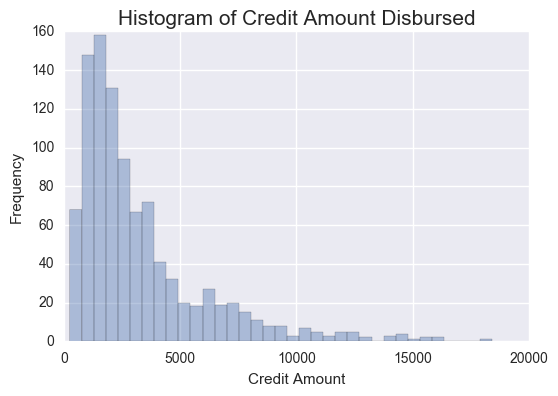

In [7]:
sns.distplot(german['Credit Amount'],kde = False)
plt.title( "Histogram of Credit Amount Disbursed", fontsize = 15)
plt.ylabel( "Frequency")

Machine Learning Implementation:

In [8]:
for col in german.columns.values:
    if german[col].dtype == 'object':
        german[col] = LabelEncoder().fit_transform(german[col])
german_train,german_test = german[features],german[label]

In [9]:
def algorithm(algoname,colors,train,test,pos):
    mean_tpr,lw,i =0.0, 2,1
    mean_fpr = np.linspace(0, 1, 100)
    fold_accuracy= []
    skfold = StratifiedKFold(n_splits=10,shuffle = True)
    for (trainindex,testindex), color in zip(skfold.split(train, test.values.ravel()), colors):
        X_train, X_test = train.loc[trainindex], train.loc[testindex]
        y_train, y_test = test.loc[trainindex], test.loc[testindex]
        model = algoname.fit(X_train,y_train.values.ravel())
        fold_accuracy.append(model.score(X_test,y_test.values.ravel()))
        result = model.predict(X_test)
        fpr, tpr, thresholds= roc_curve(y_test.values,result,pos_label=pos)
        mean_tpr += interp(mean_fpr, fpr, tpr)
        mean_tpr[0] = 0.0
        roc_auc = auc(fpr, tpr)
        #plt.step(fpr, tpr, lw=lw, color=color,label='ROC fold %d (area = %0.2f)' % (i, roc_auc))
        i+=1
    mean_tpr /= skfold.get_n_splits(train,test.values.ravel())
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    plt.step(mean_fpr, mean_tpr, color='g', linestyle='--',
             label='Mean ROC (area = %0.2f)' % mean_auc, lw=lw)
    plt.title("Average accuracy: {0:.3f}".format(np.asarray(fold_accuracy).mean()))
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.legend(loc="lower right") 
    return ("Average accuracy: {0:.3f} (+/-{1:.3f})".format(np.asarray(fold_accuracy).mean(),\
                                                            np.asarray(fold_accuracy).std()))    

## Random Forest Algorithm:

In [10]:
estimators = [10,100,300,600,800,1000]
depth = [1,2,50,100,300,800,None]
features = ['auto','sqrt',0.2]
min_sampleleaf = [1,5,10,50,100,200,500]
randomstate = [1,50,100,500,None]
colors = cycle(['brown','lightcoral','red','magenta','cyan', 'indigo', 'seagreen', 'yellow', 'blue', 'darkorange'])

In [11]:
forest = RandomForestClassifier(n_jobs=-1)
#print(algorithm(forest,colors,german_train,german_test,pos = 2))

Best number of trees in the forest

Average accuracy: 0.745 (+/-0.031) estimators:  10
Average accuracy: 0.775 (+/-0.033) estimators:  100
Average accuracy: 0.764 (+/-0.045) estimators:  300
Average accuracy: 0.771 (+/-0.031) estimators:  600
Average accuracy: 0.771 (+/-0.038) estimators:  800
Average accuracy: 0.765 (+/-0.044) estimators:  1000


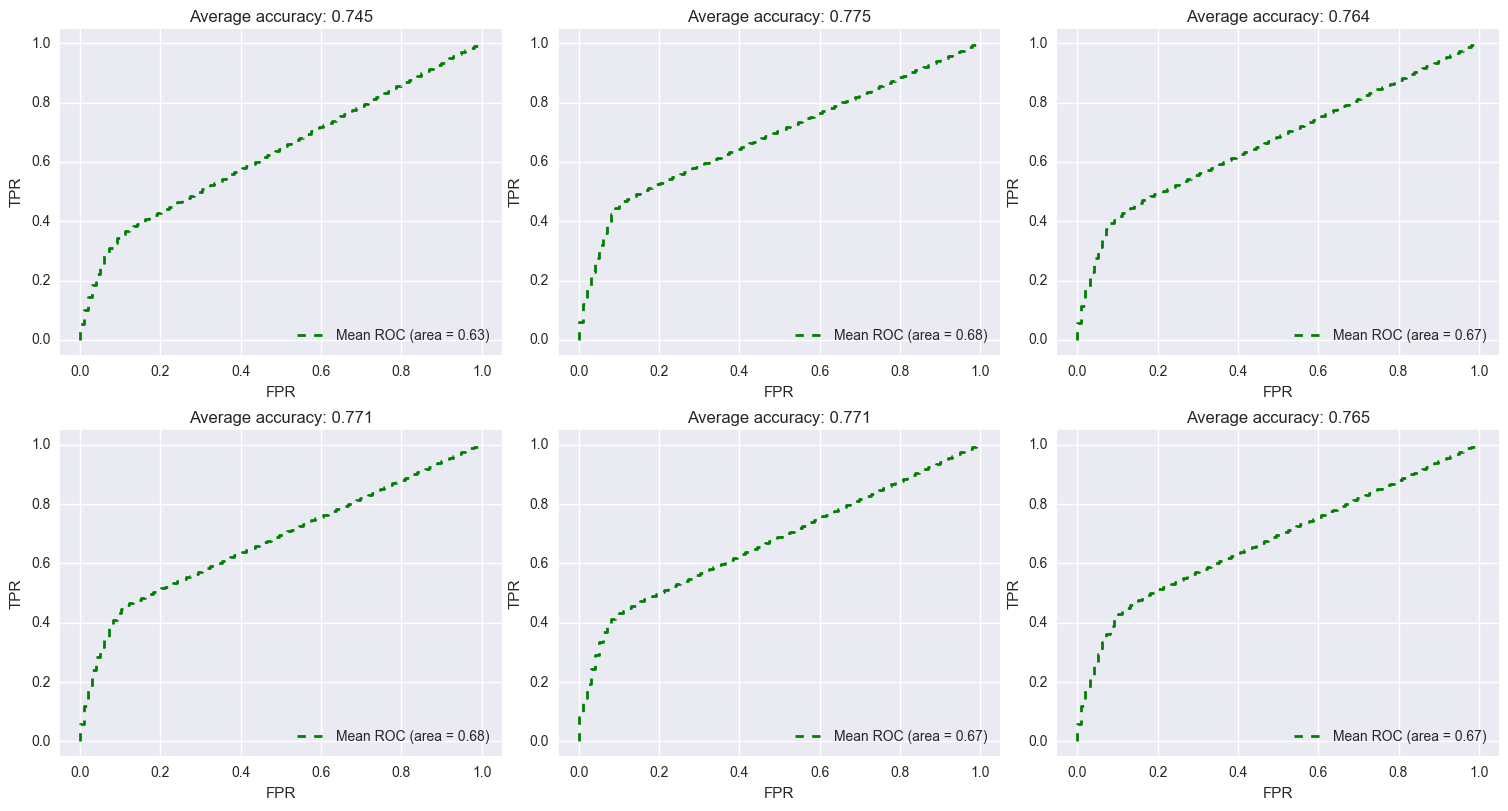

In [12]:
plt.figure(figsize=(15,8))

for i in range(len(estimators)):
    forest = RandomForestClassifier(n_estimators=estimators[i], n_jobs=-1)
    plt.subplot(2,3,i+1)
    print(algorithm(forest,colors,german_train,german_test,pos = 2),"estimators: ",estimators[i])
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)    

Maximum Depth of the tree

Average accuracy: 0.700 (+/-0.000) maximum depth:  1
Average accuracy: 0.703 (+/-0.006) maximum depth:  2
Average accuracy: 0.767 (+/-0.031) maximum depth:  50
Average accuracy: 0.769 (+/-0.022) maximum depth:  100
Average accuracy: 0.769 (+/-0.033) maximum depth:  300
Average accuracy: 0.774 (+/-0.034) maximum depth:  800
Average accuracy: 0.770 (+/-0.031) maximum depth:  None


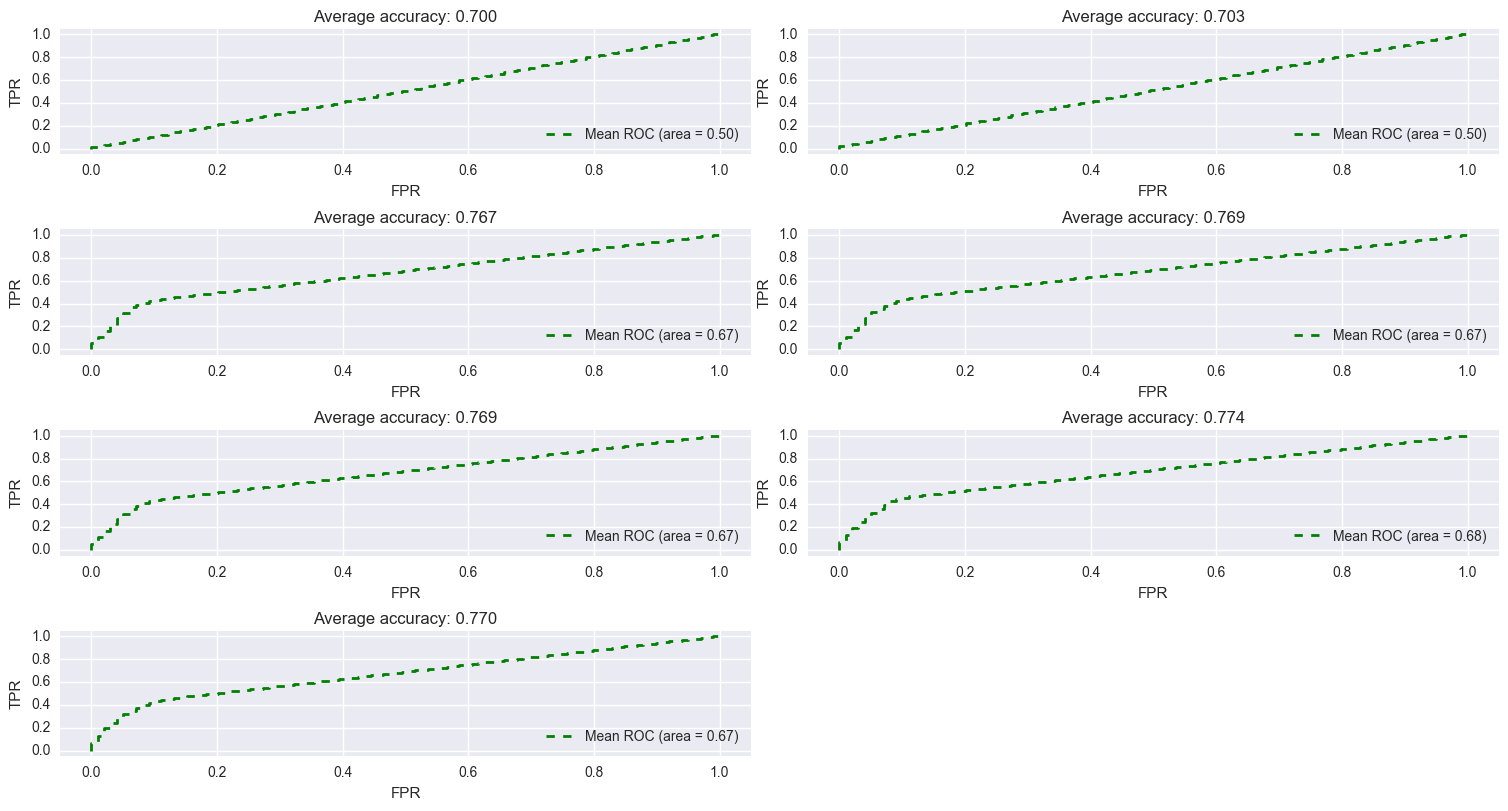

In [13]:
plt.figure(figsize=(15,8))
for i in range(len(depth)):
    forest = RandomForestClassifier(n_estimators=600, n_jobs=-1, max_depth = depth[i])
    plt.subplot(4,2,i+1)
    print(algorithm(forest,colors,german_train,german_test,pos = 2),"maximum depth: ",depth[i])
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)    

Maximum Features:

Average accuracy: 0.767 (+/-0.033) max features:  auto
Average accuracy: 0.778 (+/-0.019) max features:  sqrt
Average accuracy: 0.768 (+/-0.023) max features:  0.2


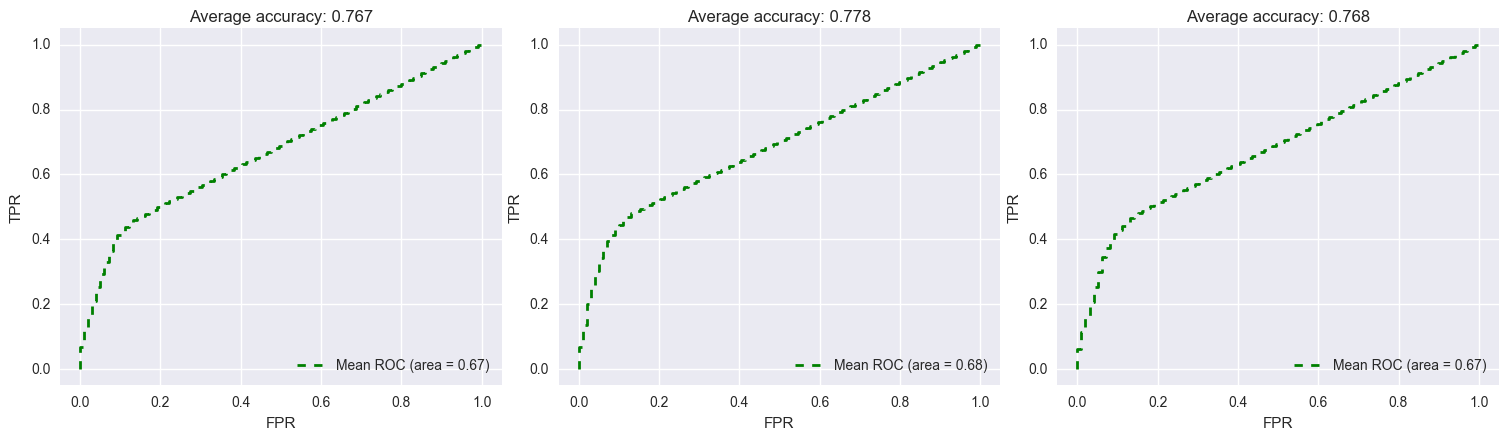

In [14]:
plt.figure(figsize=(15,8))
for i in range(len(features)):
    forest = RandomForestClassifier(n_estimators=600, n_jobs=-1, max_depth = 800,\
                                    max_features = features[i])
    plt.subplot(2,3,i+1)
    print(algorithm(forest,colors,german_train,german_test,pos = 2),"max features: ",features[i])
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)    

The minimum number of samples required to be at a leaf node

Average accuracy: 0.773 (+/-0.026) min sample leaf:  1
Average accuracy: 0.764 (+/-0.022) min sample leaf:  5
Average accuracy: 0.761 (+/-0.024) min sample leaf:  10
Average accuracy: 0.710 (+/-0.020) min sample leaf:  50
Average accuracy: 0.700 (+/-0.000) min sample leaf:  100
Average accuracy: 0.700 (+/-0.000) min sample leaf:  200
Average accuracy: 0.700 (+/-0.000) min sample leaf:  500


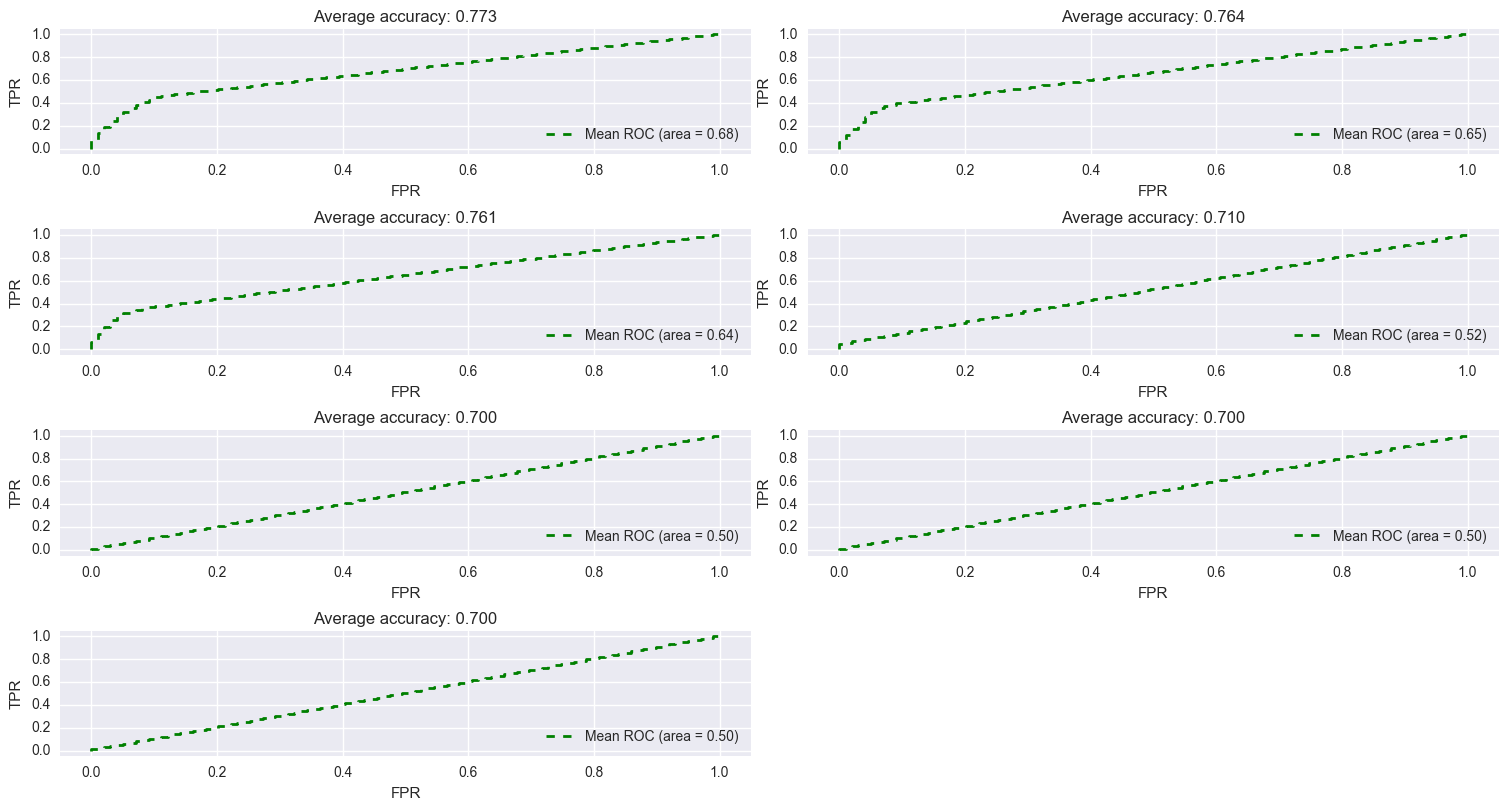

In [15]:
plt.figure(figsize=(15,8))
for i in range(len(min_sampleleaf)):
    forest = RandomForestClassifier(n_estimators=600, n_jobs=-1, max_depth = 800,max_features = 'auto',\
                                   min_samples_leaf =min_sampleleaf[i] )
    plt.subplot(4,2,i+1)
    print(algorithm(forest,colors,german_train,german_test,pos = 2),"min sample leaf: ",min_sampleleaf[i])
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)    

Random State

Average accuracy: 0.704 (+/-0.009) random state:  1
Average accuracy: 0.709 (+/-0.015) random state:  50
Average accuracy: 0.710 (+/-0.010) random state:  100
Average accuracy: 0.710 (+/-0.009) random state:  500
Average accuracy: 0.709 (+/-0.012) random state:  None


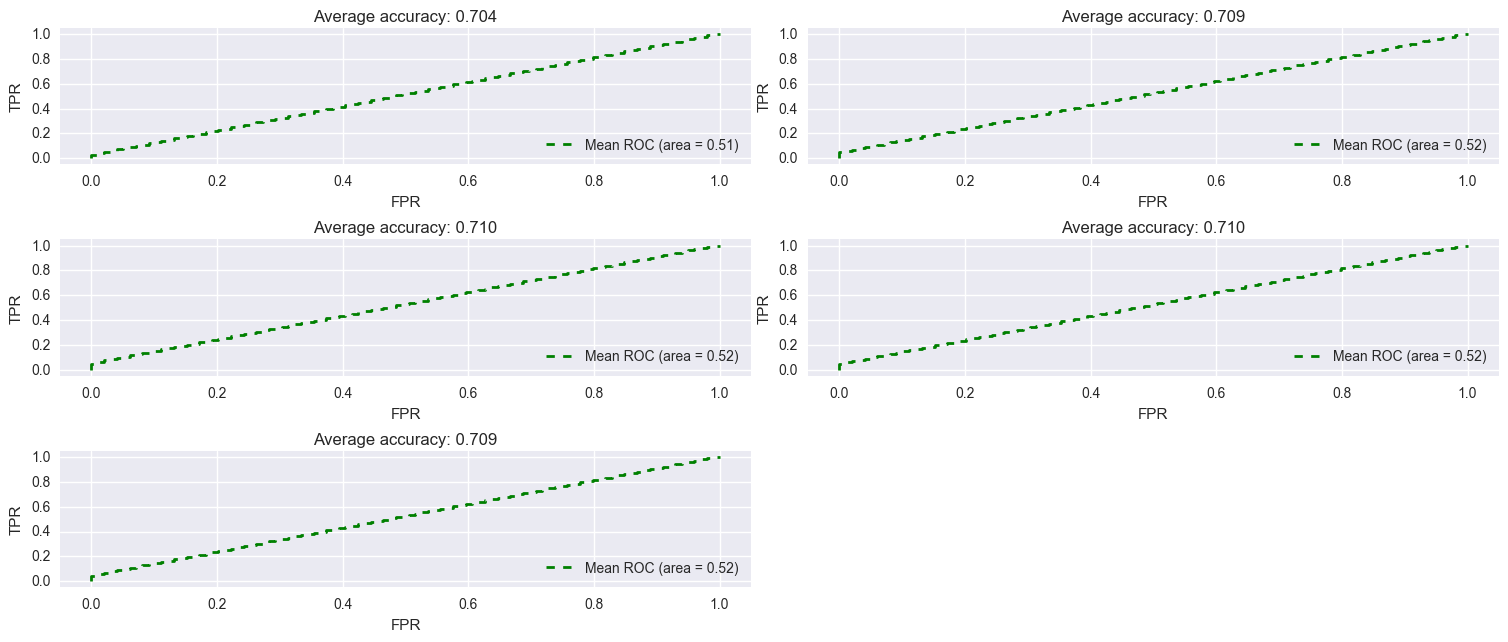

In [16]:
plt.figure(figsize=(15,8))
for i in range(len(randomstate)):
    forest = RandomForestClassifier(n_estimators=600, n_jobs=-1, max_depth = 800,max_features = 'auto',\
                                   min_samples_leaf =50,random_state=randomstate[i] )
    plt.subplot(4,2,i+1)
    print(algorithm(forest,colors,german_train,german_test,pos = 2),"random state: ",randomstate[i])
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)    

Best Features using Greedy Approach:

Average accuracy: 0.707 (+/-0.006)


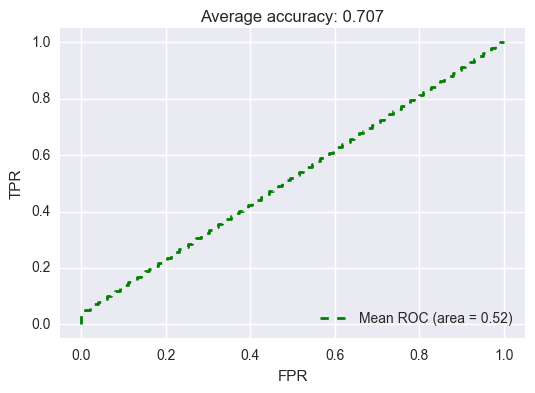

In [17]:
forest = RandomForestClassifier(n_estimators=600, n_jobs=-1, max_depth = 800,max_features = 'auto',\
                                   min_samples_leaf =50,random_state = None)
print(algorithm(forest,colors,german_train,german_test,pos = 2))

## Logistic Regression

In [18]:
penalties = ['l1','l2']
cvalue = [1.0,0.1,0.5,0.8,0.9]
solve = ['newton-cg', 'lbfgs', 'liblinear', 'sag']
tolerance = []
classweight = ['balanced',None]
max_iter = [10,100,500,1000]
randomState = [None,10,100,500,1000,1024]

Selecting from L1, L2 Regularization

Average accuracy: 0.755 (+/-0.030) Penalty:  l1
Average accuracy: 0.761 (+/-0.036) Penalty:  l2


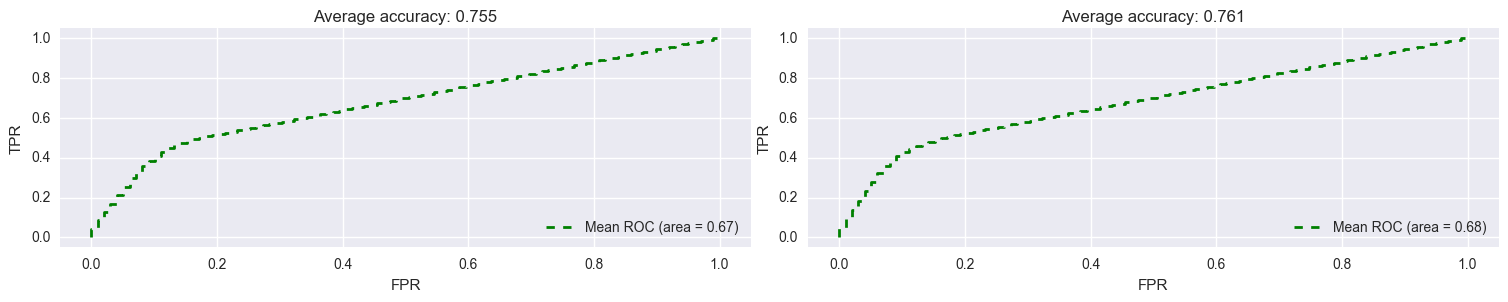

In [19]:
plt.figure(figsize=(15,8))
for i in range(len(penalties)):
    logistic = LogisticRegression(n_jobs = -1, penalty= penalties[i])
    plt.subplot(3,2,i+1)
    print(algorithm(logistic,colors,german_train,german_test,pos = 2),"Penalty: ",penalties[i])
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)        

Selecting Algorithm for optimization

Average accuracy: 0.759 (+/-0.034) Solver:  newton-cg
Average accuracy: 0.751 (+/-0.038) Solver:  lbfgs
Average accuracy: 0.760 (+/-0.034) Solver:  liblinear
Average accuracy: 0.700 (+/-0.000) Solver:  sag


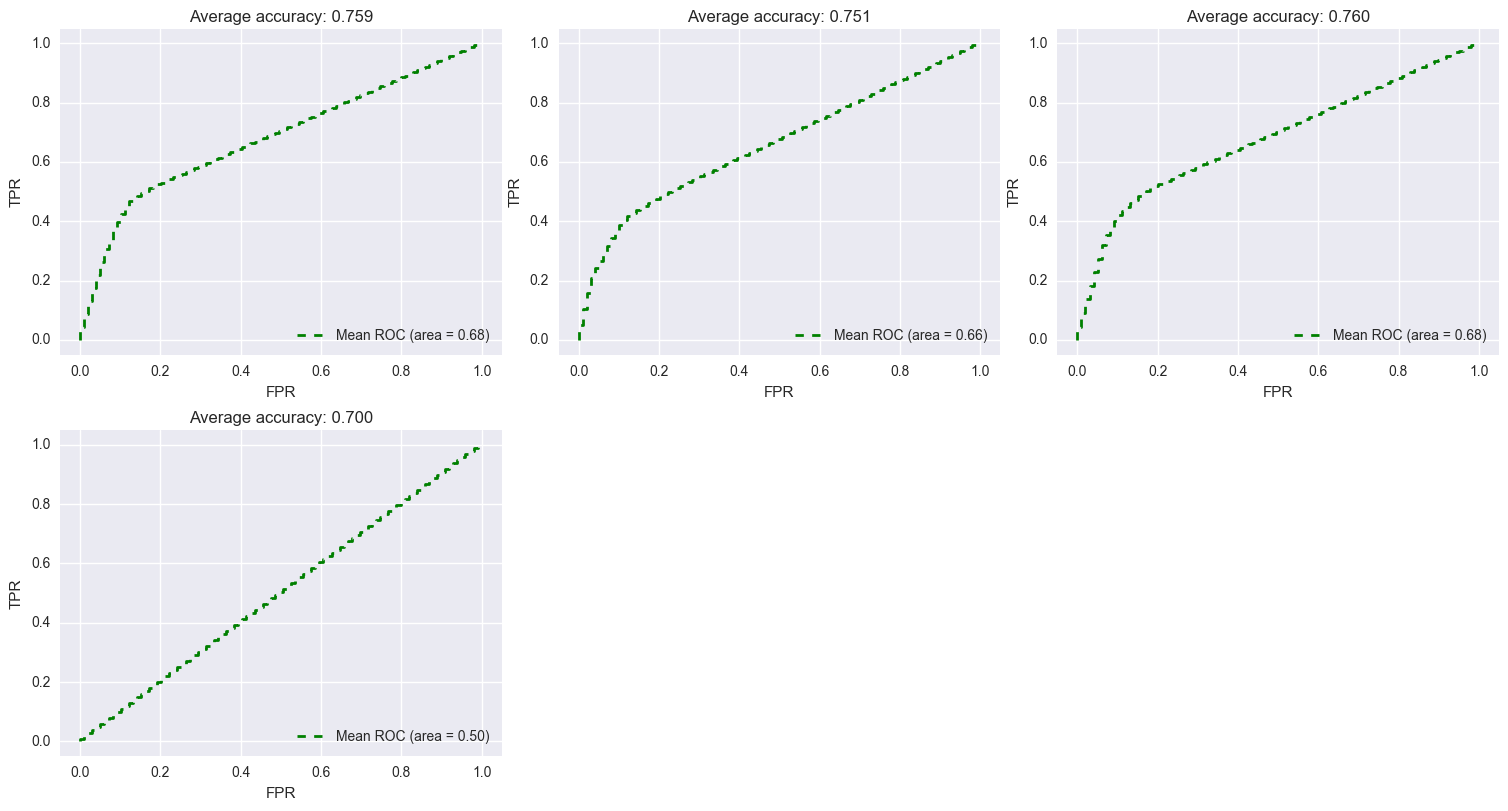

In [20]:
plt.figure(figsize=(15,8))
for i in range(len(solve)):
    logistic = LogisticRegression(n_jobs = -1, penalty= 'l2',  solver = solve[i])
    plt.subplot(2,3,i+1)
    print(algorithm(logistic,colors,german_train,german_test,pos = 2),"Solver: ",solve[i])
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)        

Selecting best C value (Inverse of Regularization Strength)

Average accuracy: 0.758 (+/-0.023) C:  1.0
Average accuracy: 0.754 (+/-0.023) C:  0.1
Average accuracy: 0.753 (+/-0.035) C:  0.5
Average accuracy: 0.758 (+/-0.038) C:  0.8
Average accuracy: 0.757 (+/-0.033) C:  0.9


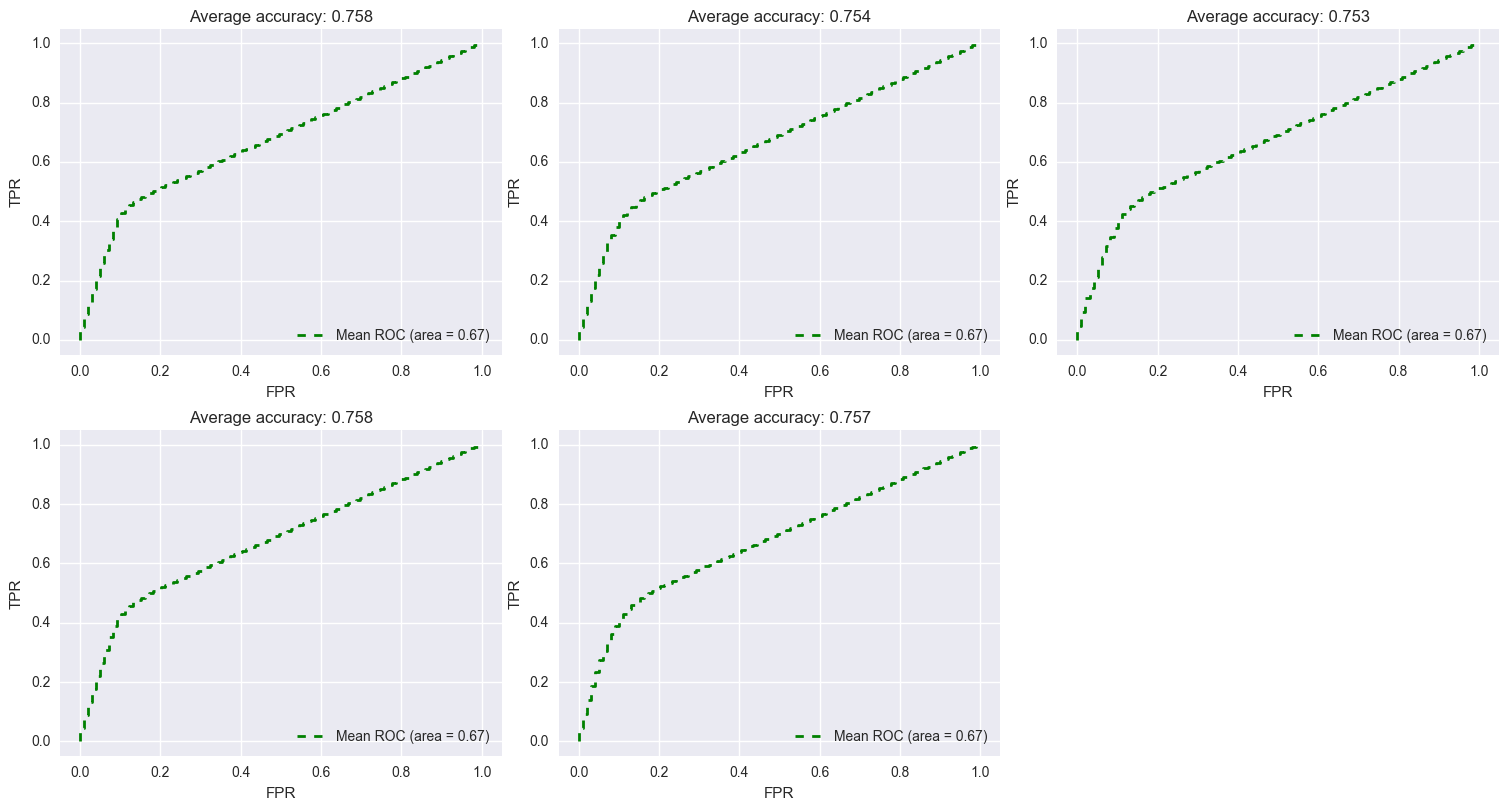

In [21]:
plt.figure(figsize=(15,8))
for i in range(len(cvalue)):
    logistic = LogisticRegression(n_jobs = -1, penalty= 'l2', solver = 'liblinear', C = cvalue[i])
    plt.subplot(2,3,i+1)
    print(algorithm(logistic,colors,german_train,german_test,pos = 2),"C: ",cvalue[i])
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)        

Should you give class weights or not?

Average accuracy: 0.709 (+/-0.065) Class Weight:  balanced
Average accuracy: 0.762 (+/-0.040) Class Weight:  None


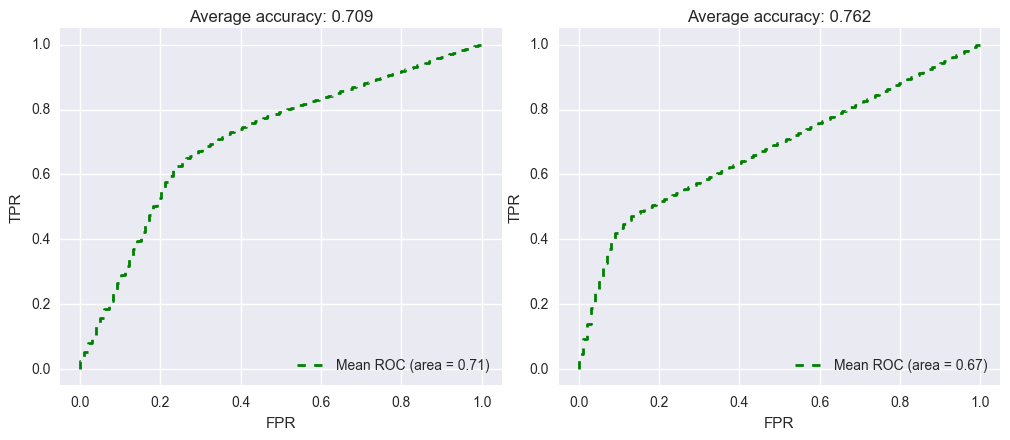

In [22]:
plt.figure(figsize=(15,8))
for i in range(len(classweight)):
    logistic = LogisticRegression(n_jobs = -1, penalty= 'l2', C = 0.5 , solver = 'liblinear',\
                                  class_weight = classweight[i])
    plt.subplot(2,3,i+1)
    print(algorithm(logistic,colors,german_train,german_test,pos = 2),"Class Weight: ",classweight[i])
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)        

Max Iterations:

Average accuracy: 0.706 (+/-0.018) Max iterations:  10
Average accuracy: 0.760 (+/-0.031) Max iterations:  100
Average accuracy: 0.754 (+/-0.048) Max iterations:  500
Average accuracy: 0.757 (+/-0.033) Max iterations:  1000


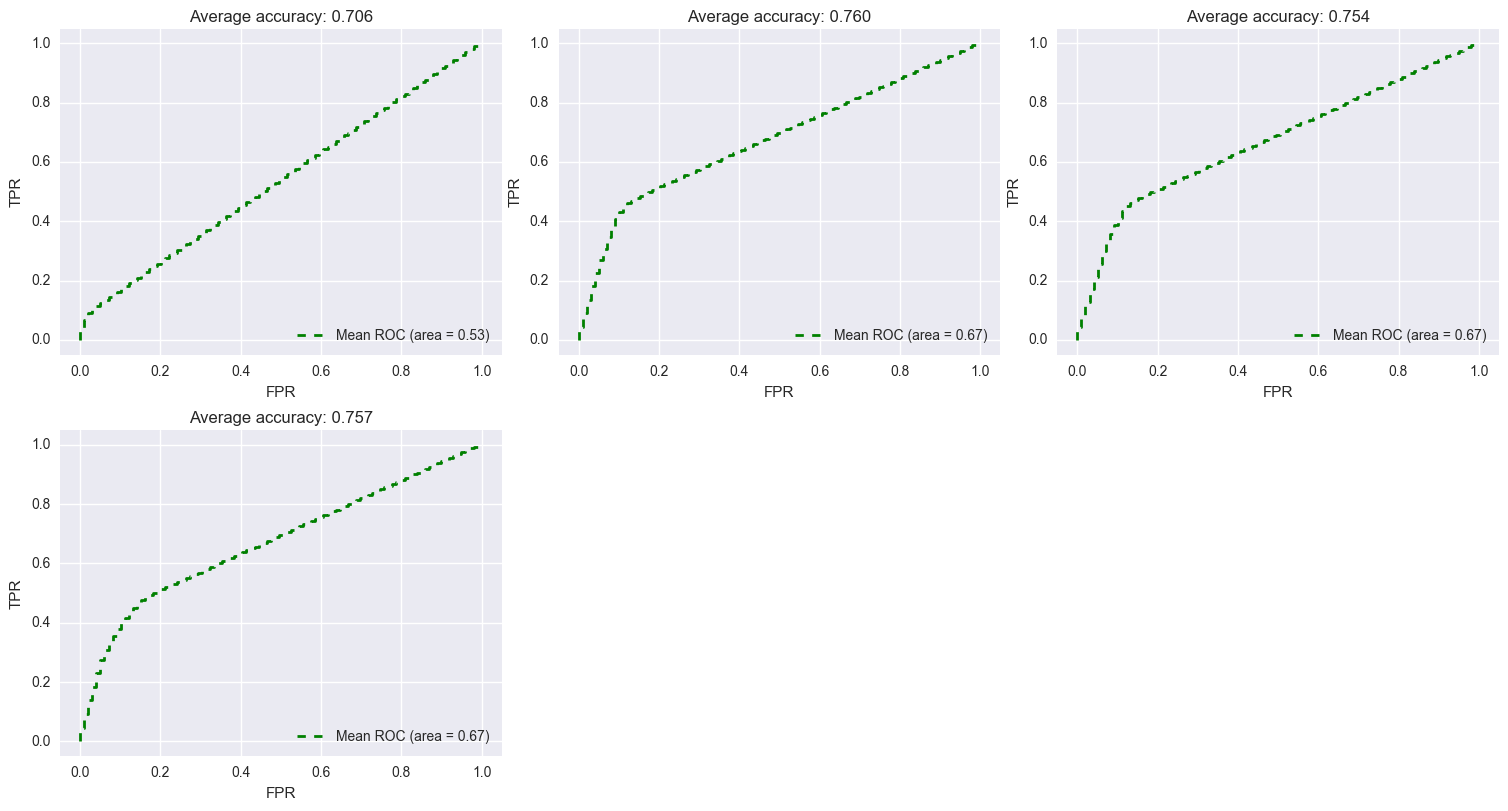

In [23]:
plt.figure(figsize=(15,8))
for i in range(len(max_iter)):
    logistic = LogisticRegression(n_jobs = -1, penalty= 'l2', C = 0.5 , solver = 'liblinear',\
                                  class_weight = None ,max_iter = max_iter[i])
    plt.subplot(2,3,i+1)
    print(algorithm(logistic,colors,german_train,german_test,pos = 2),"Max iterations: ",max_iter[i])
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)        

Ignoring Maximum iterations because of two reasons:<br/>
1. Accuracy decreasing <br/>
2. Useful only for the newton-cg, sag and lbfgs solvers

Best Random State

Average accuracy: 0.760 (+/-0.027) Random State:  None
Average accuracy: 0.763 (+/-0.042) Random State:  10
Average accuracy: 0.755 (+/-0.032) Random State:  100
Average accuracy: 0.754 (+/-0.020) Random State:  500
Average accuracy: 0.754 (+/-0.039) Random State:  1000
Average accuracy: 0.753 (+/-0.030) Random State:  1024


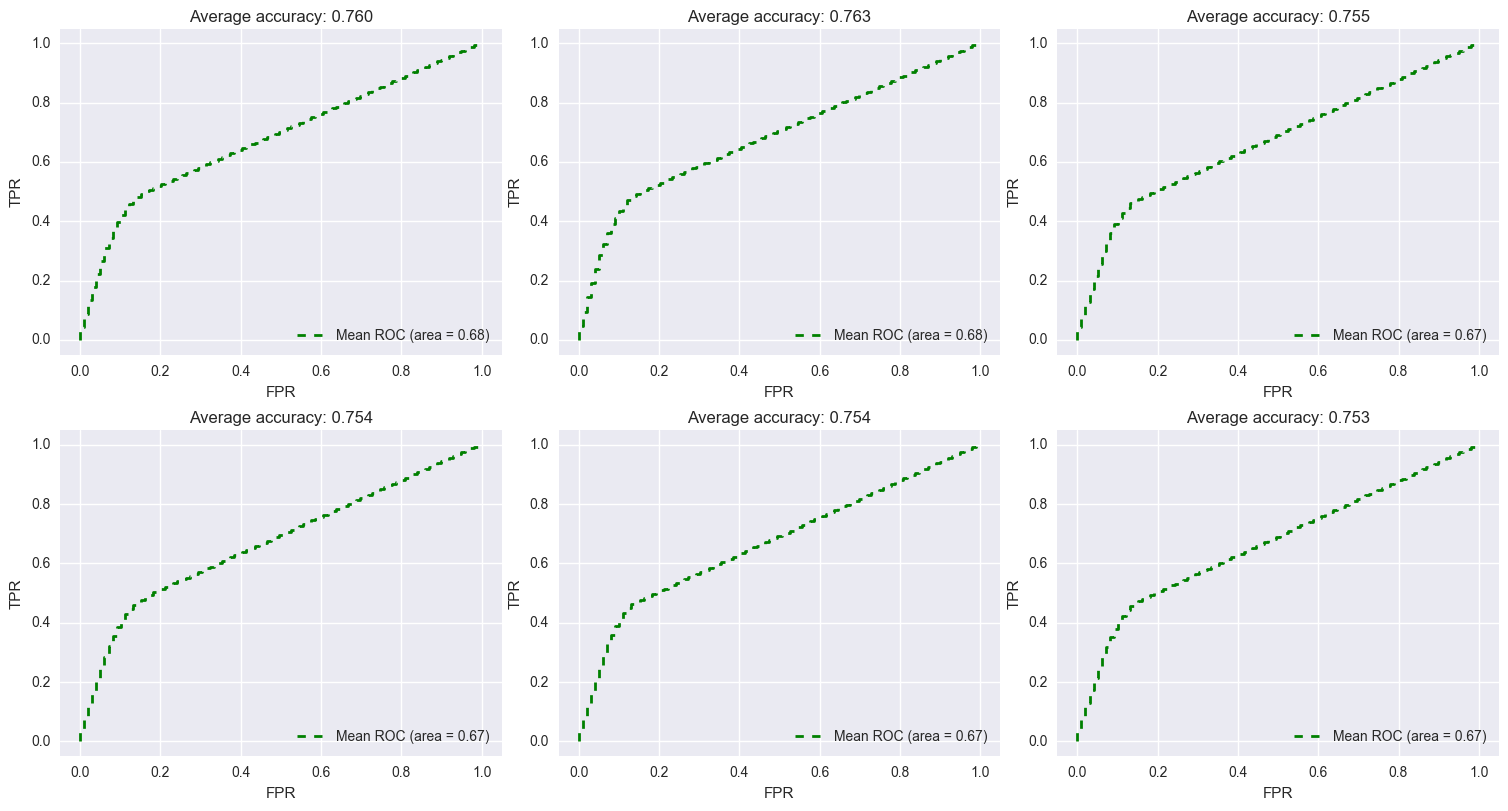

In [24]:
plt.figure(figsize=(15,8))
for i in range(len(randomState)):
    logistic = LogisticRegression(n_jobs = -1, penalty= 'l2', C = 0.5 , solver = 'liblinear',\
                                  class_weight = None,random_state = randomState[i])
    plt.subplot(2,3,i+1)
    print(algorithm(logistic,colors,german_train,german_test,pos = 2),"Random State: ",randomState[i])
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)        

Selecting Best Features

Average accuracy: 0.754 (+/-0.040)


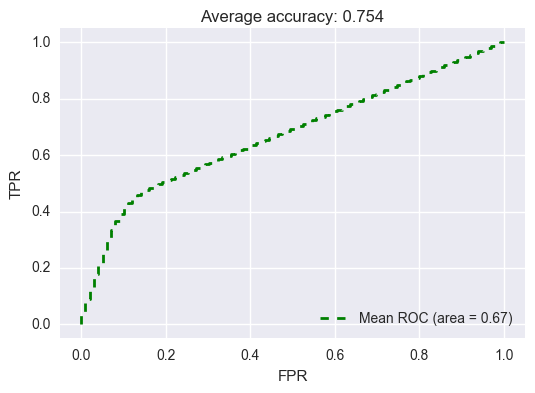

In [25]:
logistic = LogisticRegression(n_jobs = -1, penalty= 'l2', C = 0.5 , solver = 'liblinear',\
                                  class_weight = None,random_state = 500)
print(algorithm(logistic,colors,german_train,german_test,pos = 2))

Naive Bayes

Average accuracy: 0.734 (+/-0.047)


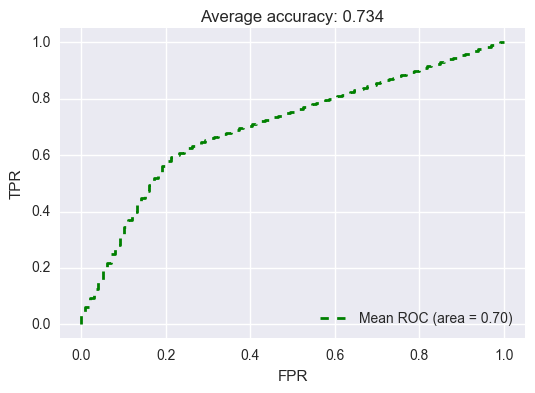

In [26]:
naive = GaussianNB()
print(algorithm(naive,colors,german_train,german_test,pos = 2))

k Nearest Neighbors

In [27]:
neighbors = [5,10,50,100]
weight = ['uniform','distance']
algo = ['auto', 'ball_tree', 'kd_tree', 'brute']


Playing with K for getting optimal K

Average accuracy: 0.669 (+/-0.050) Neighbors:  5
Average accuracy: 0.693 (+/-0.036) Neighbors:  10
Average accuracy: 0.704 (+/-0.012) Neighbors:  50
Average accuracy: 0.703 (+/-0.009) Neighbors:  100


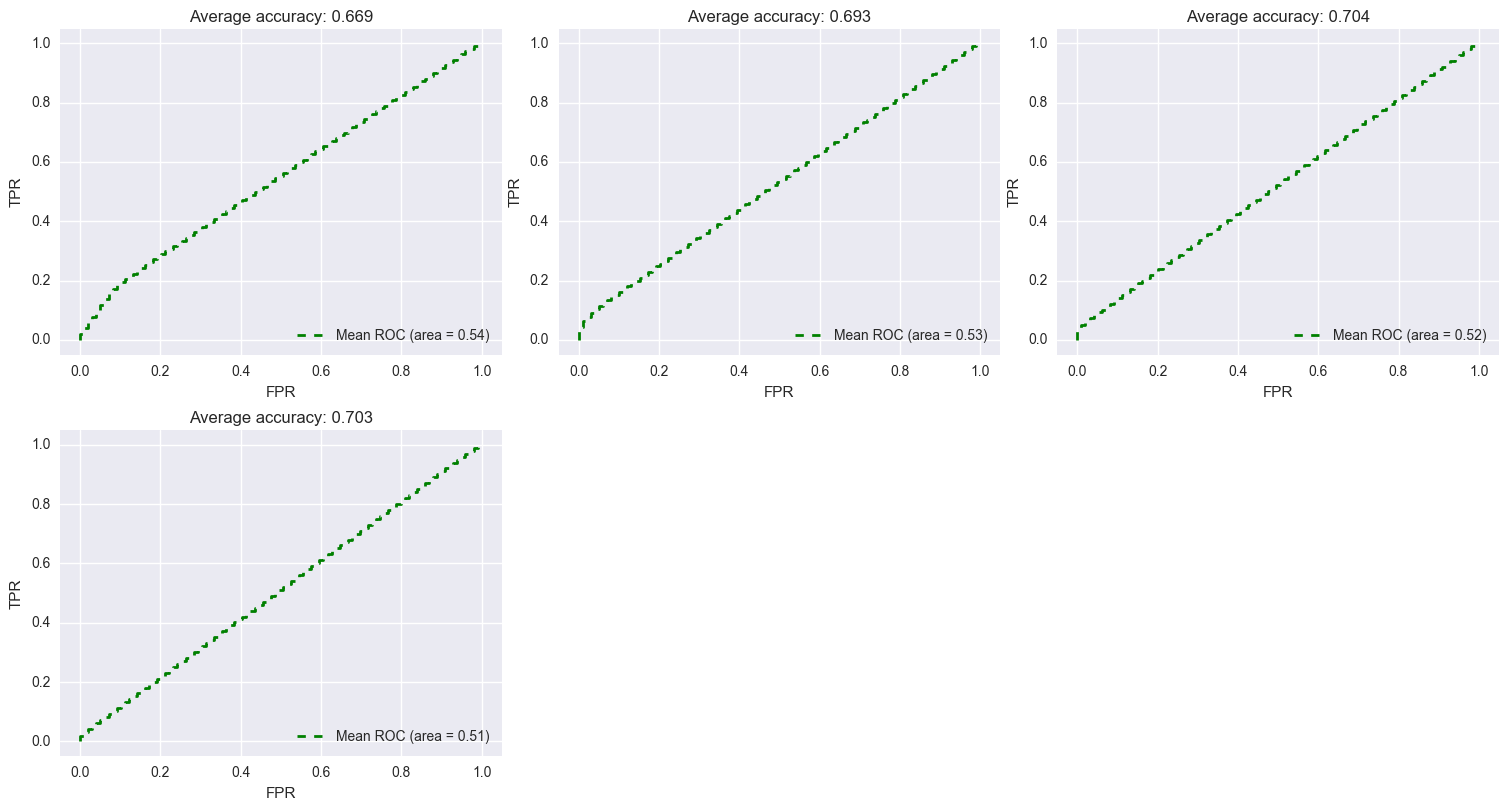

In [28]:
plt.figure(figsize=(15,8))
for i in range(len(neighbors)):
    knneigh = KNeighborsClassifier(n_jobs = -1,n_neighbors= neighbors[i])
    plt.subplot(2,3,i+1)
    print(algorithm(knneigh,colors,german_train,german_test,pos = 2),"Neighbors: ",neighbors[i])
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)        

Considering Class Weights

Average accuracy: 0.654 (+/-0.041) Weights:  uniform
Average accuracy: 0.649 (+/-0.056) Weights:  distance


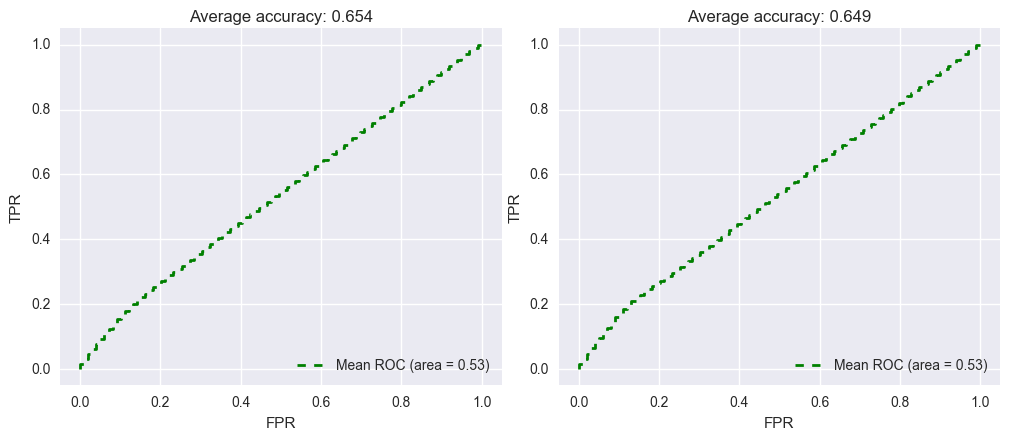

In [29]:
plt.figure(figsize=(15,8))
for i in range(len(weight)):
    knneigh = KNeighborsClassifier(n_jobs = -1,n_neighbors=5, weights = weight[i])
    plt.subplot(2,3,i+1)
    print(algorithm(knneigh,colors,german_train,german_test,pos = 2),"Weights: ",weight[i])
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)        

Which type of Algorithm  will perform better?

Average accuracy: 0.638 (+/-0.026) Algorithm:  auto
Average accuracy: 0.656 (+/-0.043) Algorithm:  ball_tree
Average accuracy: 0.655 (+/-0.044) Algorithm:  kd_tree
Average accuracy: 0.652 (+/-0.030) Algorithm:  brute


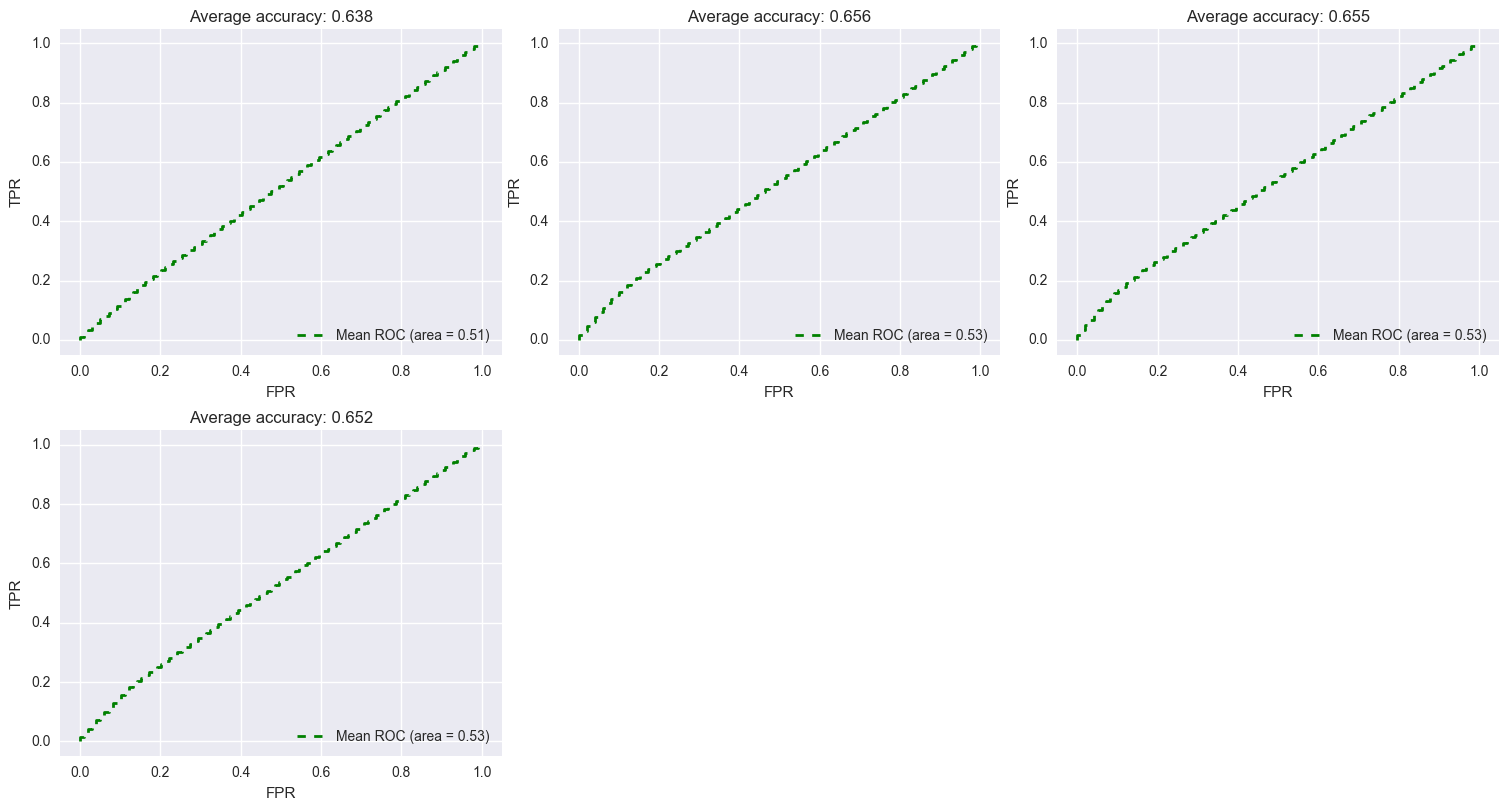

In [30]:
plt.figure(figsize=(15,8))
for i in range(len(algo)):
    knneigh = KNeighborsClassifier(n_jobs = -1,n_neighbors=5, weights = 'uniform', algorithm = algo[i])
    plt.subplot(2,3,i+1)
    print(algorithm(knneigh,colors,german_train,german_test,pos = 2),"Algorithm: ",algo[i])
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)        

Best Features

Average accuracy: 0.645 (+/-0.035)


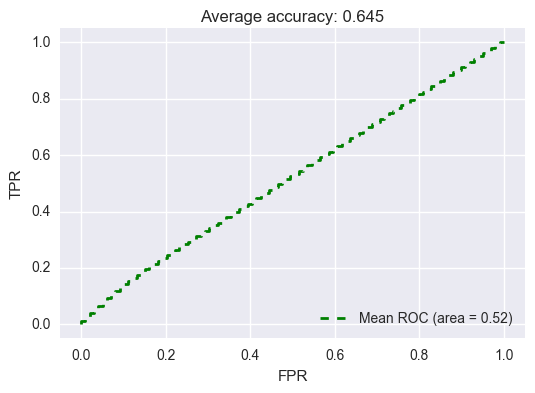

In [31]:
knneigh = KNeighborsClassifier(n_jobs = -1,n_neighbors=5, weights = 'uniform', algorithm = 'auto')
print(algorithm(knneigh,colors,german_train,german_test,pos = 2))

Support Vector Machine

In [32]:
dual = [True,False]

Dual or Primal formulation

Average accuracy: 0.658 (+/-0.099) Dual:  True
Average accuracy: 0.758 (+/-0.031) Dual:  False


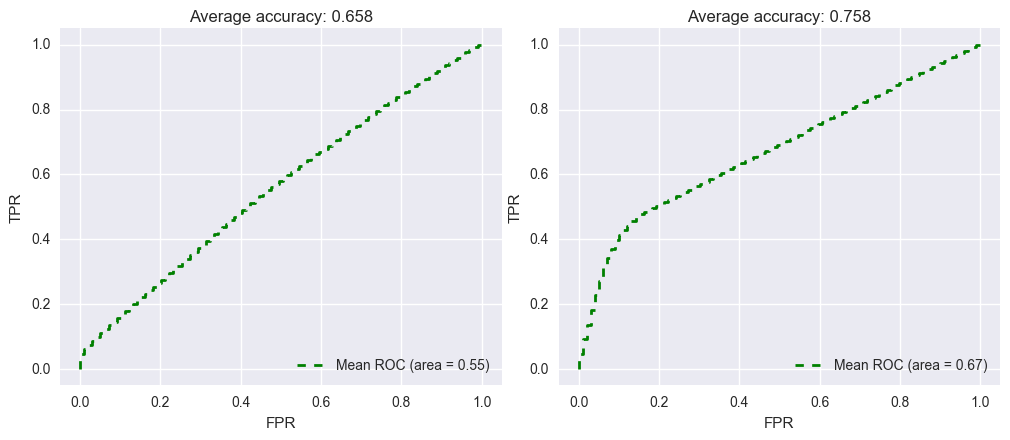

In [33]:
plt.figure(figsize=(15,8))
for i in range(len(dual)):
    svm = LinearSVC(dual = dual[i])
    plt.subplot(2,3,i+1)
    print(algorithm(svm,colors,german_train,german_test,pos = 2),"Dual: ",dual[i])
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)        

Selecting best C value (Inverse of Regularization Strength)

Average accuracy: 0.758 (+/-0.019) C:  1.0
Average accuracy: 0.760 (+/-0.034) C:  0.1
Average accuracy: 0.756 (+/-0.027) C:  0.5
Average accuracy: 0.756 (+/-0.037) C:  0.8
Average accuracy: 0.758 (+/-0.032) C:  0.9


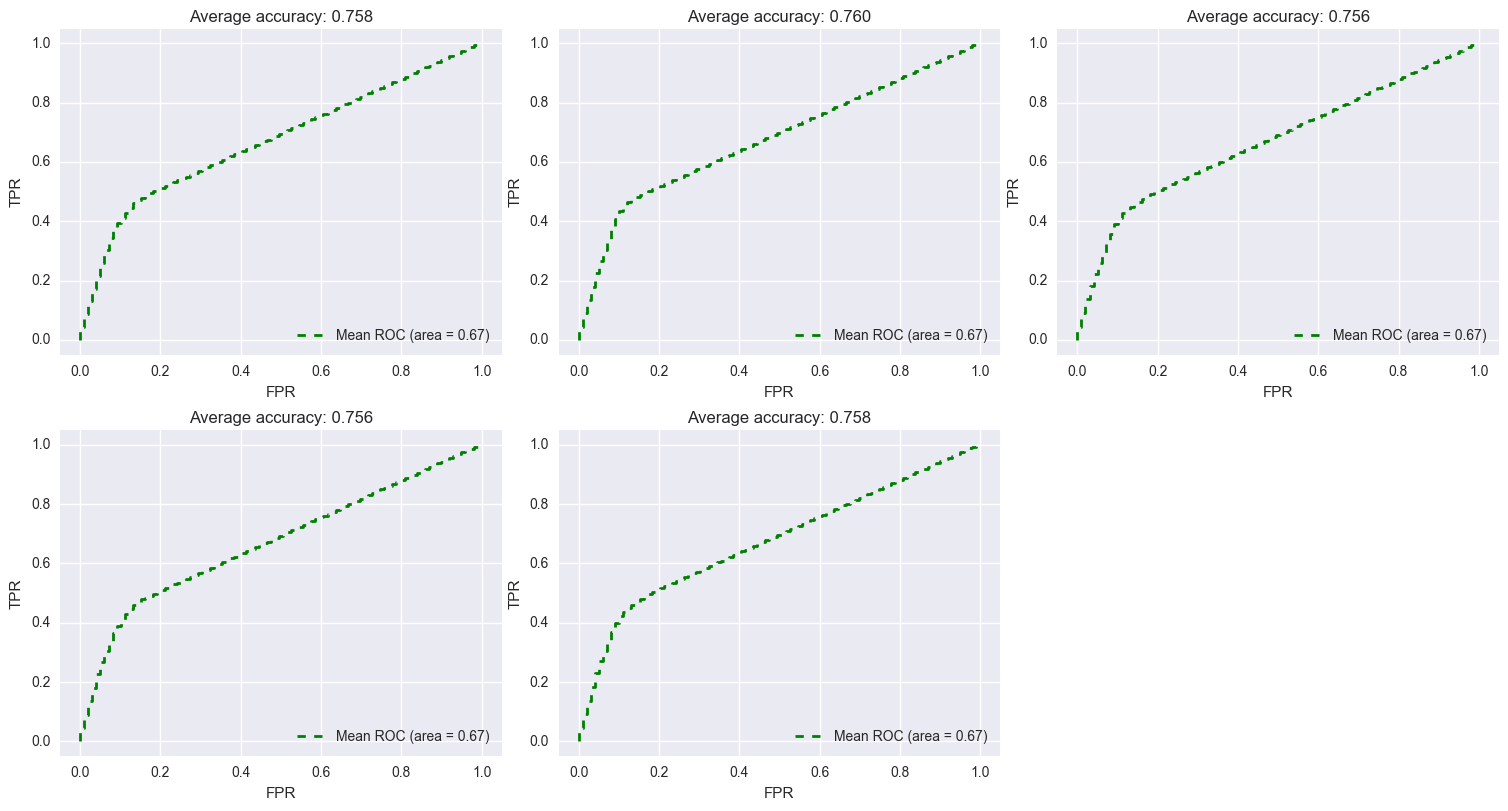

In [34]:
plt.figure(figsize=(15,8))
for i in range(len(cvalue)):
    svm = LinearSVC(dual = False, C = cvalue[i])
    plt.subplot(2,3,i+1)
    print(algorithm(svm,colors,german_train,german_test,pos = 2),"C: ",cvalue[i])
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)        

L1 or L2 Regularization

Average accuracy: 0.759 (+/-0.034) Penalty:  l1
Average accuracy: 0.757 (+/-0.046) Penalty:  l2


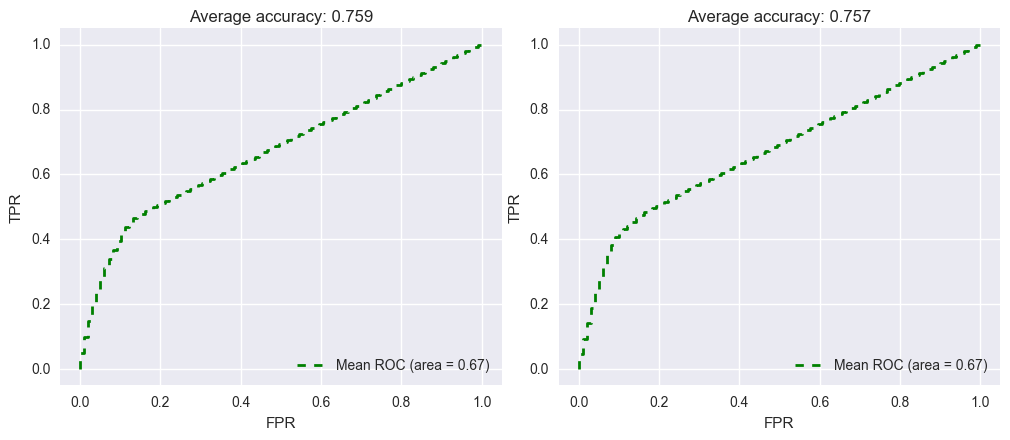

In [35]:
plt.figure(figsize=(15,8))
for i in range(len(penalties)):
    svm = LinearSVC(dual = False, C = 1, penalty = penalties[i])
    plt.subplot(2,3,i+1)
    print(algorithm(svm,colors,german_train,german_test,pos = 2),"Penalty: ",penalties[i])
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)        

Class Weights

Average accuracy: 0.714 (+/-0.046) Class Weight:  balanced
Average accuracy: 0.753 (+/-0.044) Class Weight:  None


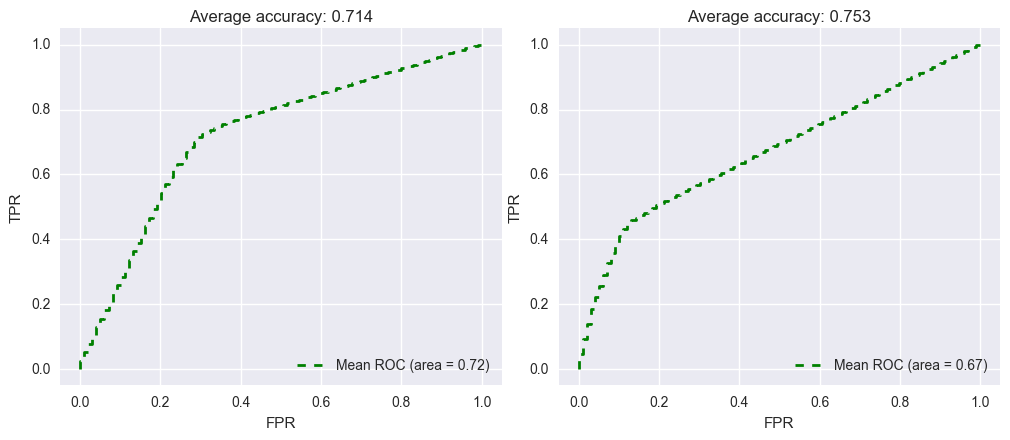

In [36]:
plt.figure(figsize=(15,8))
for i in range(len(classweight)):
    svm = LinearSVC(dual = False, C = 1, penalty = 'l1', class_weight=classweight[i])
    plt.subplot(2,3,i+1)
    print(algorithm(svm,colors,german_train,german_test,pos = 2),"Class Weight: ",classweight[i])
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)        

Max Iterations

Average accuracy: 0.757 (+/-0.025) Max Iterations:  10
Average accuracy: 0.757 (+/-0.028) Max Iterations:  100
Average accuracy: 0.761 (+/-0.025) Max Iterations:  500
Average accuracy: 0.760 (+/-0.045) Max Iterations:  1000


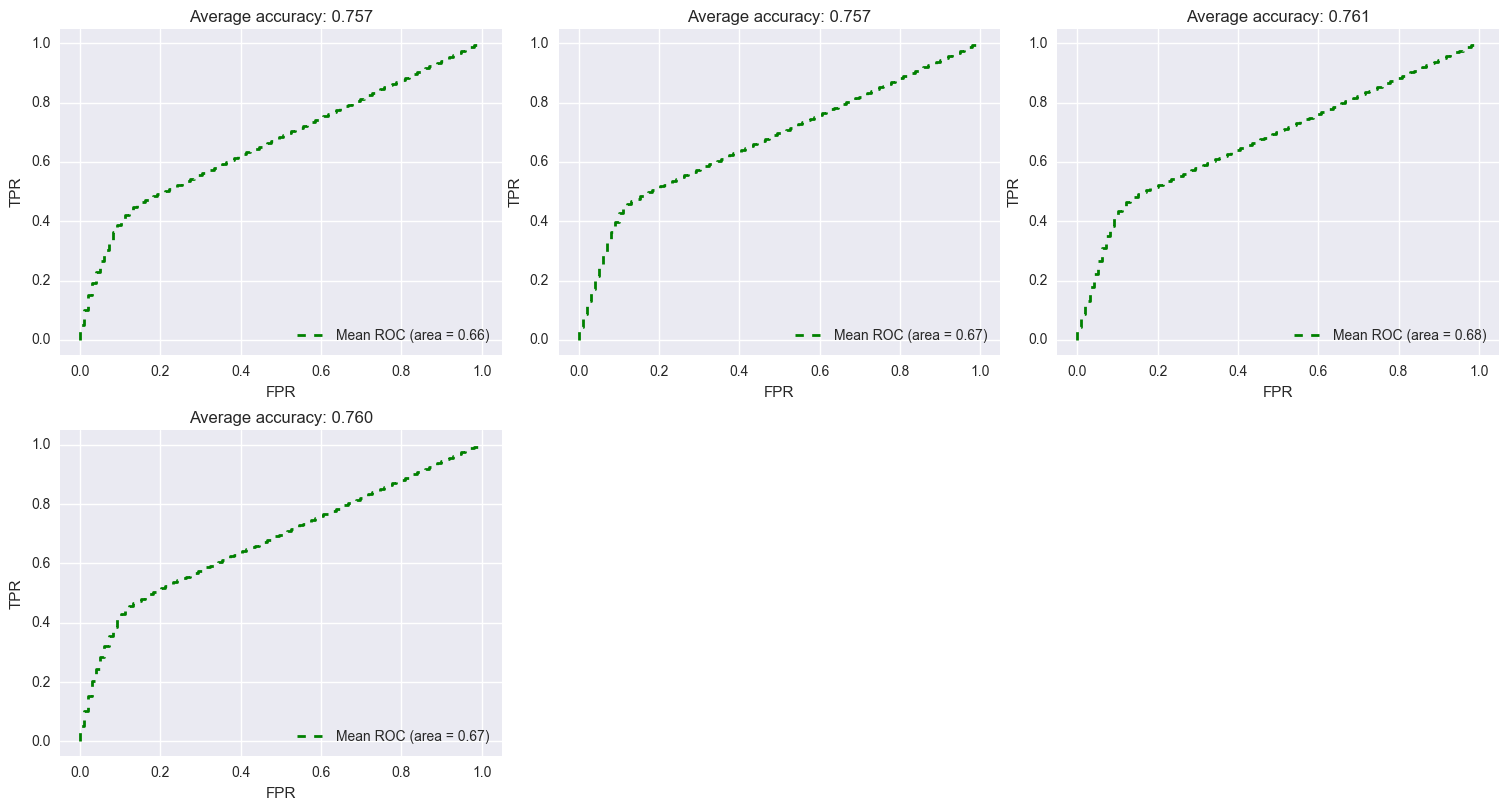

In [37]:
plt.figure(figsize=(15,8))
for i in range(len(max_iter)):
    svm = LinearSVC(dual = False, C = 1, penalty = 'l1', class_weight=None,max_iter=max_iter[i])
    plt.subplot(2,3,i+1)
    print(algorithm(svm,colors,german_train,german_test,pos = 2),"Max Iterations: ",max_iter[i])
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)        

Random State

Average accuracy: 0.760 (+/-0.030) Random State:  None
Average accuracy: 0.757 (+/-0.029) Random State:  10
Average accuracy: 0.764 (+/-0.057) Random State:  100
Average accuracy: 0.766 (+/-0.034) Random State:  500
Average accuracy: 0.757 (+/-0.038) Random State:  1000
Average accuracy: 0.765 (+/-0.036) Random State:  1024


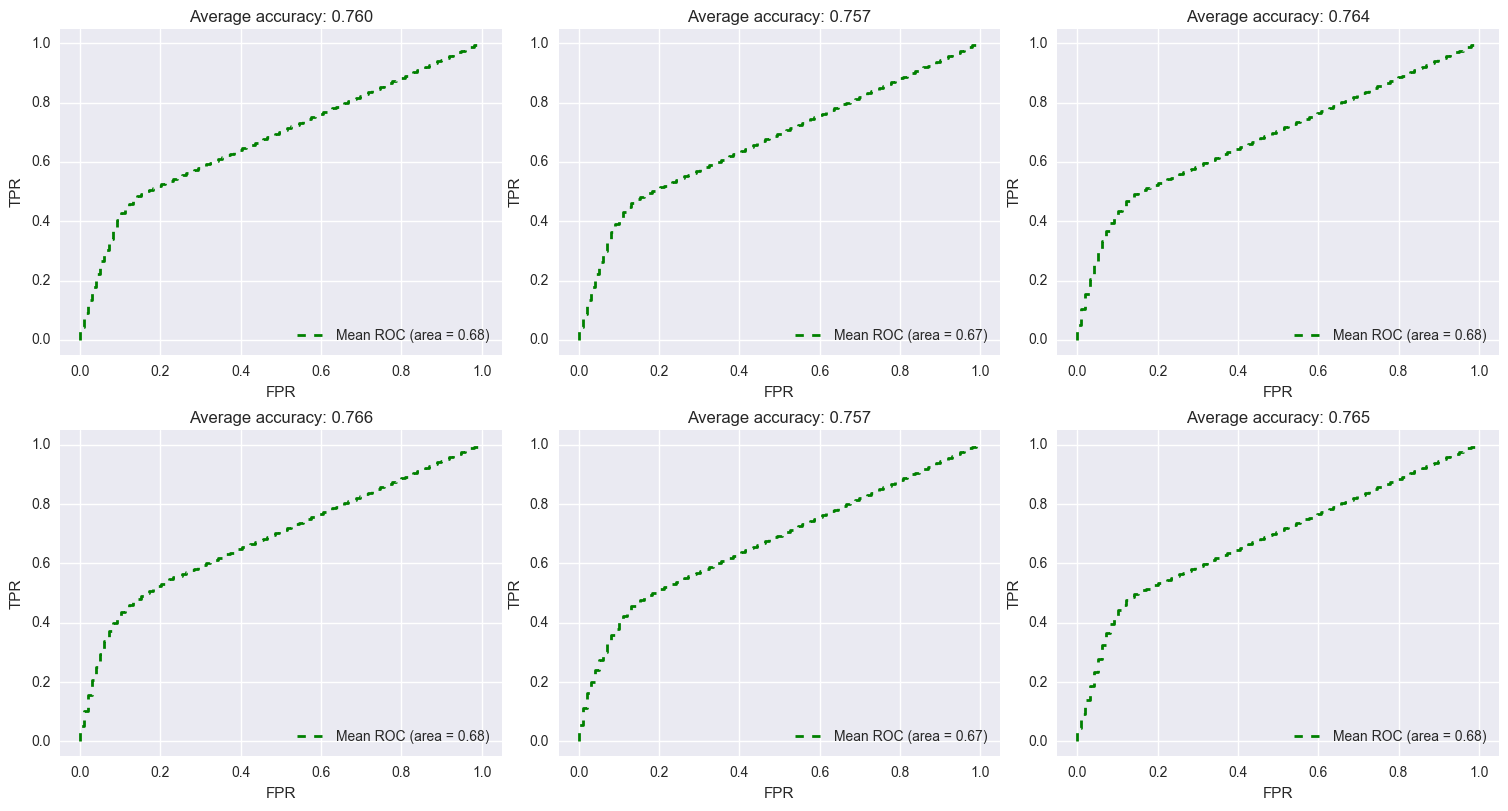

In [38]:
plt.figure(figsize=(15,8))
for i in range(len(randomState)):
    svm = LinearSVC(dual = False, C = 1, penalty = 'l1', class_weight=None,max_iter=1000,random_state=randomState[i])
    plt.subplot(2,3,i+1)
    print(algorithm(svm,colors,german_train,german_test,pos = 2),"Random State: ",randomState[i])
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)        

Best Features

Average accuracy: 0.757 (+/-0.045)


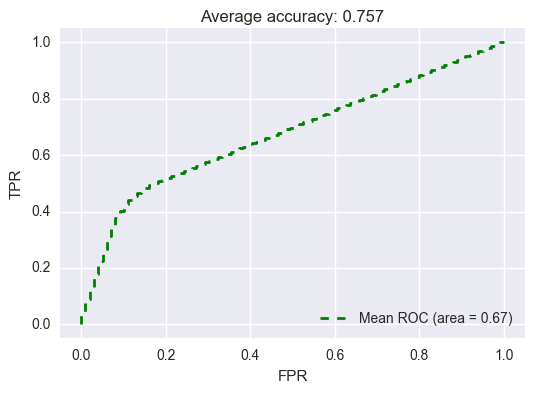

In [39]:
svm = LinearSVC(dual = False, C = 1, penalty = 'l1', class_weight=None,max_iter=1000,random_state=1000)
print(algorithm(svm,colors,german_train,german_test,pos = 2))

kNN implementation

In [40]:
import math
import operator
def euclidean_distance(data1,data2):
    result = 0.0
    for val in range(len(data2)):
        result += (data1[val]-data2[val])**2
    return math.sqrt(result)
def knn(train,test,k):
    dist,kneighbors = [],[]
    for a,c in train.iterrows():
        distance = euclidean_distance(c,test)
        dist.append((c,distance))
        dist.sort(key=operator.itemgetter(1))
    for i in range(k):
        kneighbors.append(dist[i][0])
    return kneighbors  
def majorityVote(kneighbors):
    vote = {}
    for i in range(len(kneighbors)):
        lst = kneighbors[i][-1]
        if lst in vote:
            vote[lst]+=1
        else:
            vote[lst]=1
    majority = max(vote.items(), key=operator.itemgetter(1))[0]
    return majority

In [41]:
X_train, X_test, y_train, y_test = train_test_split(german.iloc[:,:-1], german.iloc[:,-1:], test_size=0.20, random_state=4212)
train = pd.concat([X_train, y_train], axis=1)

In [42]:
predictions = []
for i,c in X_test.iterrows():
    kneighbors = knn(train,c,5)
    responses = majorityVote(kneighbors)
    predictions.append(responses)
mine_knn = pd.DataFrame( data={"predicted":predictions,"actual":y_test.values.ravel()} ) 
print ("accuracy_score: ", accuracy_score(mine_knn['actual'],mine_knn['predicted']))

accuracy_score:  0.68


In [43]:
crx = pd.read_csv('crx.data',header=None,sep = ',')
cols = ['A1','A2','A3','A4','A5','A6','A7','A8','A9','A10','A11','A12','A13','A14','A15']
classlabel = ['A16']
columns = cols + classlabel
crx.columns = columns

In [44]:
crx.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 690 entries, 0 to 689
Data columns (total 16 columns):
A1     690 non-null object
A2     690 non-null object
A3     690 non-null float64
A4     690 non-null object
A5     690 non-null object
A6     690 non-null object
A7     690 non-null object
A8     690 non-null float64
A9     690 non-null object
A10    690 non-null object
A11    690 non-null int64
A12    690 non-null object
A13    690 non-null object
A14    690 non-null object
A15    690 non-null int64
A16    690 non-null object
dtypes: float64(2), int64(2), object(12)
memory usage: 86.3+ KB


In [45]:
for col in crx.columns.values:
    if crx[col].dtype == 'object':
        crx[col] = LabelEncoder().fit_transform(crx[col])
crx_train, crx_test = crx[cols],crx[classlabel]        

In [46]:
crx_test['A16'].value_counts()

1    383
0    307
Name: A16, dtype: int64

In [47]:
forest = RandomForestClassifier(n_jobs=-1)
forest

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=-1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

Estimators

Average accuracy: 0.864 (+/-0.027) estimators:  10
Average accuracy: 0.876 (+/-0.028) estimators:  100
Average accuracy: 0.874 (+/-0.047) estimators:  300
Average accuracy: 0.884 (+/-0.020) estimators:  600
Average accuracy: 0.882 (+/-0.043) estimators:  800
Average accuracy: 0.878 (+/-0.033) estimators:  1000


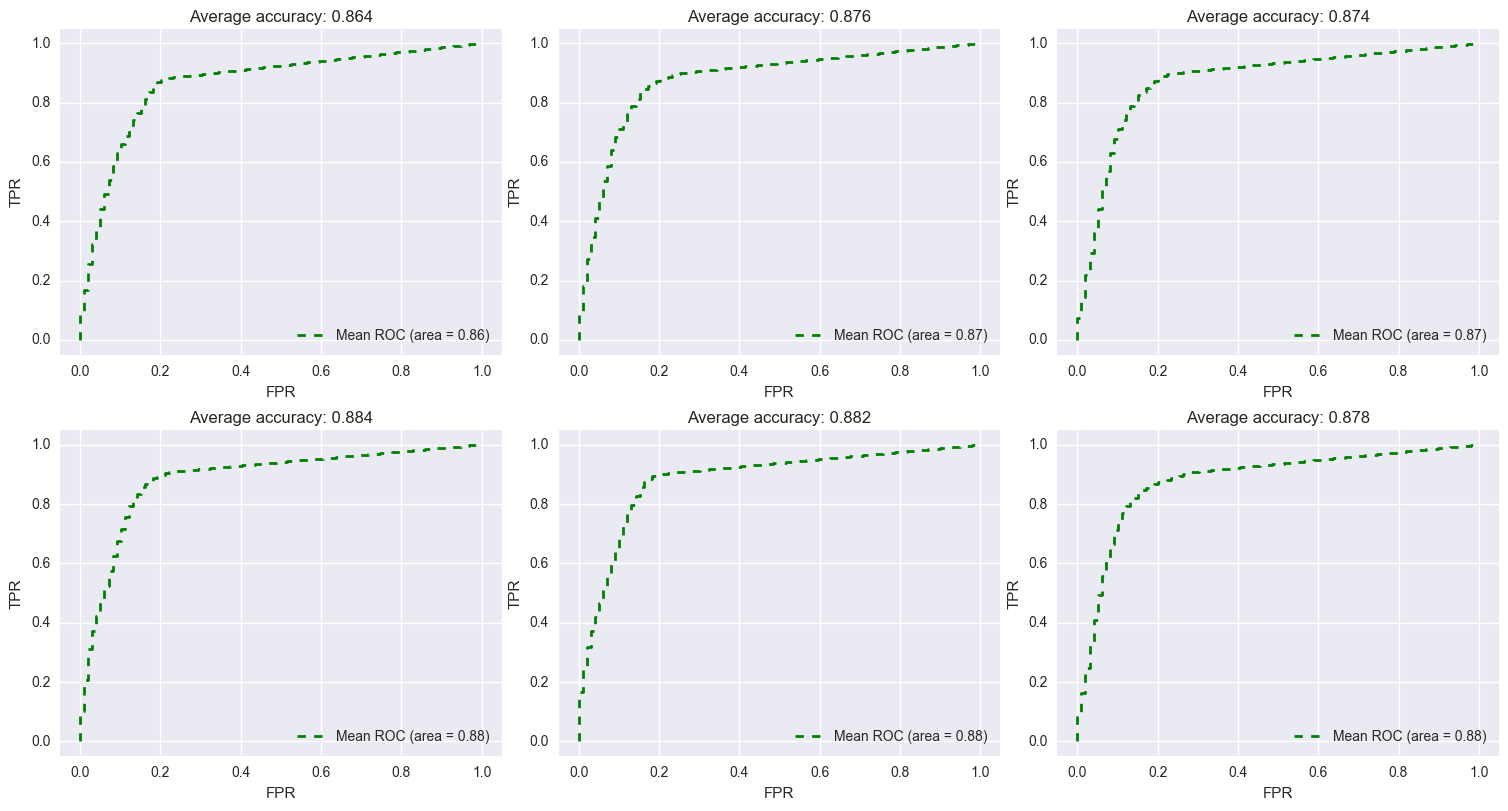

In [48]:
plt.figure(figsize=(15,8))

for i in range(len(estimators)):
    forest = RandomForestClassifier(n_estimators=estimators[i], n_jobs=-1)
    plt.subplot(2,3,i+1)
    print(algorithm(forest,colors,crx_train,crx_test,pos = None),"estimators: ",estimators[i])
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)    

Maximum Depth

Average accuracy: 0.843 (+/-0.037) Max Depth:  1
Average accuracy: 0.868 (+/-0.025) Max Depth:  2
Average accuracy: 0.883 (+/-0.035) Max Depth:  50
Average accuracy: 0.883 (+/-0.032) Max Depth:  100
Average accuracy: 0.881 (+/-0.019) Max Depth:  300
Average accuracy: 0.881 (+/-0.025) Max Depth:  800
Average accuracy: 0.875 (+/-0.026) Max Depth:  None


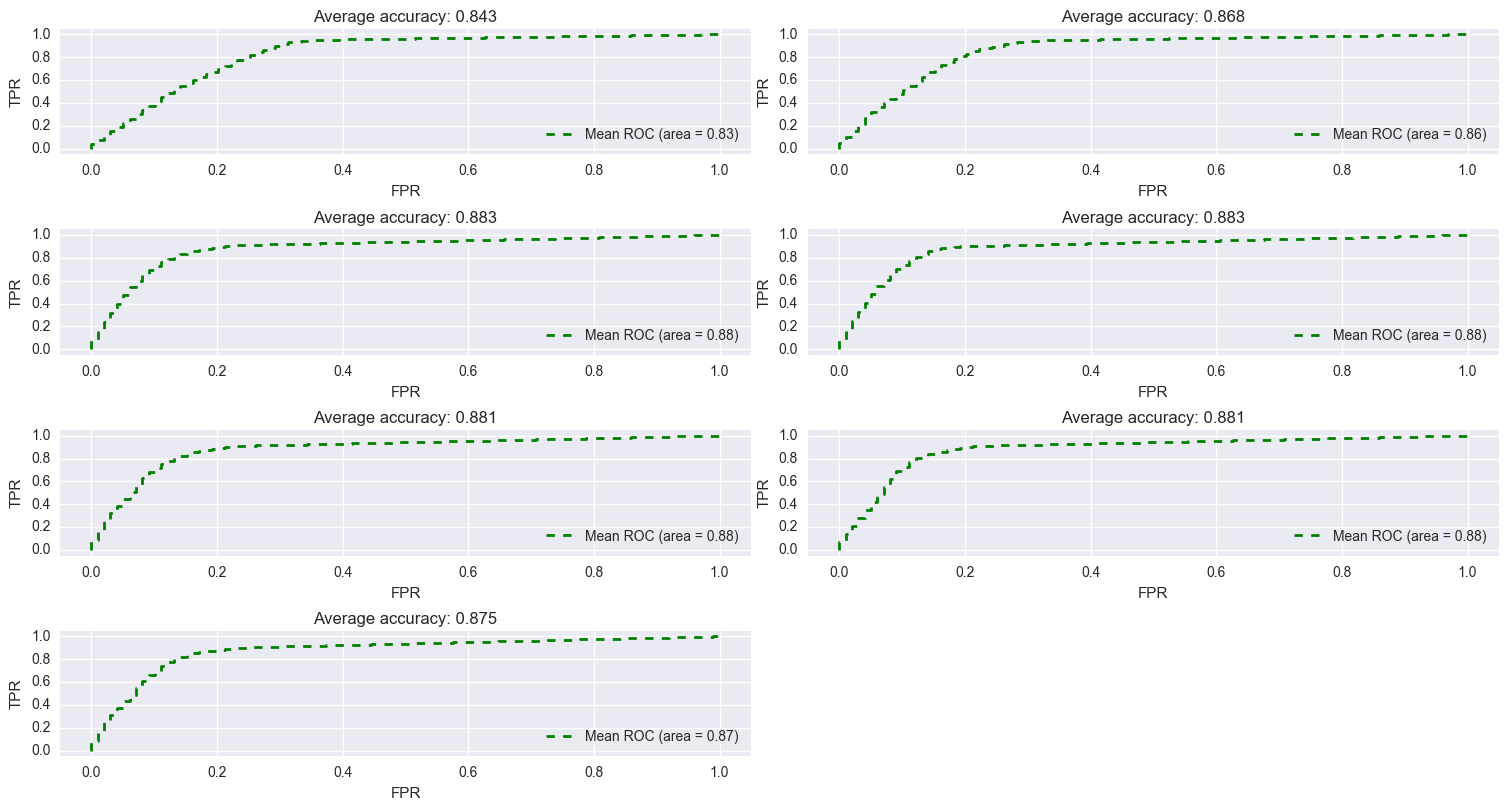

In [49]:
plt.figure(figsize=(15,8))

for i in range(len(depth)):
    forest = RandomForestClassifier(n_estimators=600, n_jobs=-1, max_depth = depth[i])
    plt.subplot(4,2,i+1)
    print(algorithm(forest,colors,crx_train,crx_test,pos = None),"Max Depth: ",depth[i])
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)    

Average accuracy: 0.873 (+/-0.032) max features:  auto
Average accuracy: 0.877 (+/-0.034) max features:  sqrt
Average accuracy: 0.872 (+/-0.032) max features:  0.2


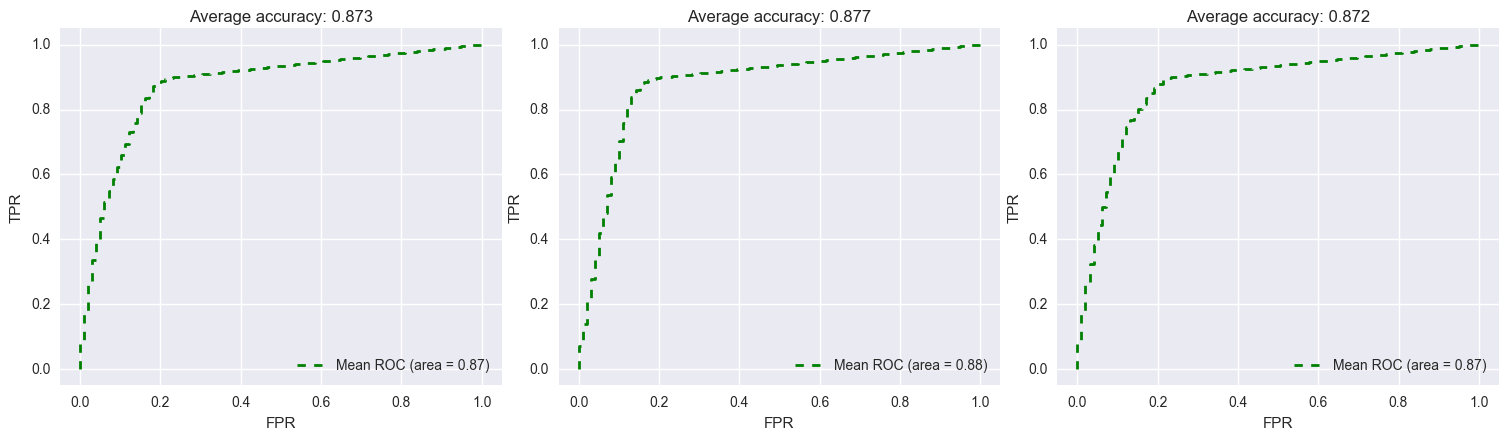

In [50]:
plt.figure(figsize=(15,8))
for i in range(len(features)):
    forest = RandomForestClassifier(n_estimators=600, n_jobs=-1, max_depth = 800,    \
                                    max_features = features[i])
    plt.subplot(2,3,i+1)
    print(algorithm(forest,colors,crx_train,crx_test,pos = None),"max features: ",features[i])
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)    

Average accuracy: 0.878 (+/-0.026) min sample leaf:  1
Average accuracy: 0.882 (+/-0.033) min sample leaf:  5
Average accuracy: 0.874 (+/-0.035) min sample leaf:  10
Average accuracy: 0.864 (+/-0.031) min sample leaf:  50
Average accuracy: 0.858 (+/-0.041) min sample leaf:  100
Average accuracy: 0.555 (+/-0.004) min sample leaf:  200
Average accuracy: 0.555 (+/-0.004) min sample leaf:  500


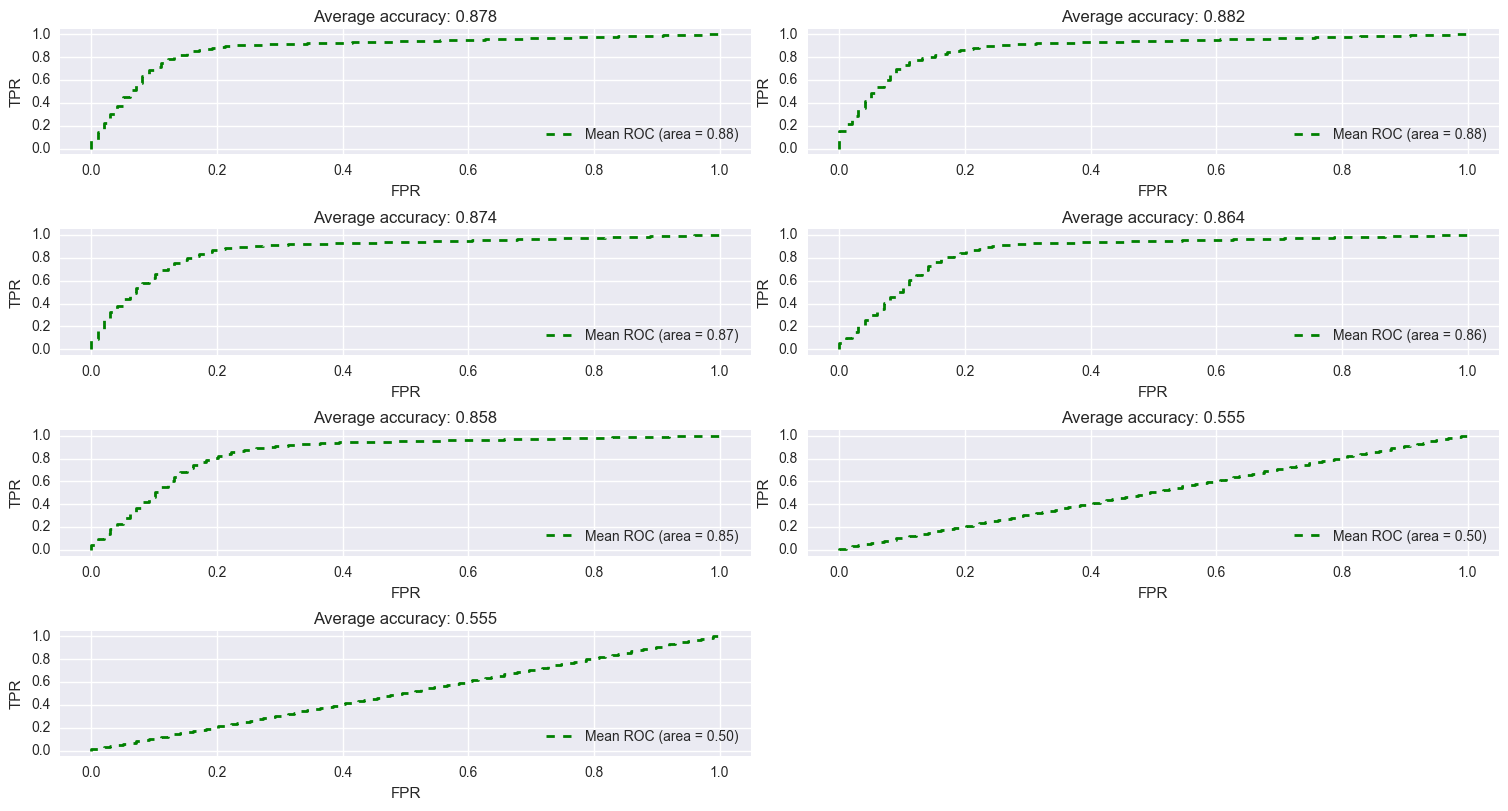

In [51]:
plt.figure(figsize=(15,8))
for i in range(len(min_sampleleaf)):
    forest = RandomForestClassifier(n_estimators=600, n_jobs=-1, max_depth = 800,max_features = 'auto',                                   min_samples_leaf =min_sampleleaf[i] )
    plt.subplot(4,2,i+1)
    print(algorithm(forest,colors,crx_train,crx_test,pos = None),"min sample leaf: ",min_sampleleaf[i])
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0) 

Average accuracy: 0.865 (+/-0.034) random state:  1
Average accuracy: 0.858 (+/-0.045) random state:  50
Average accuracy: 0.866 (+/-0.040) random state:  100
Average accuracy: 0.858 (+/-0.042) random state:  500
Average accuracy: 0.861 (+/-0.051) random state:  None


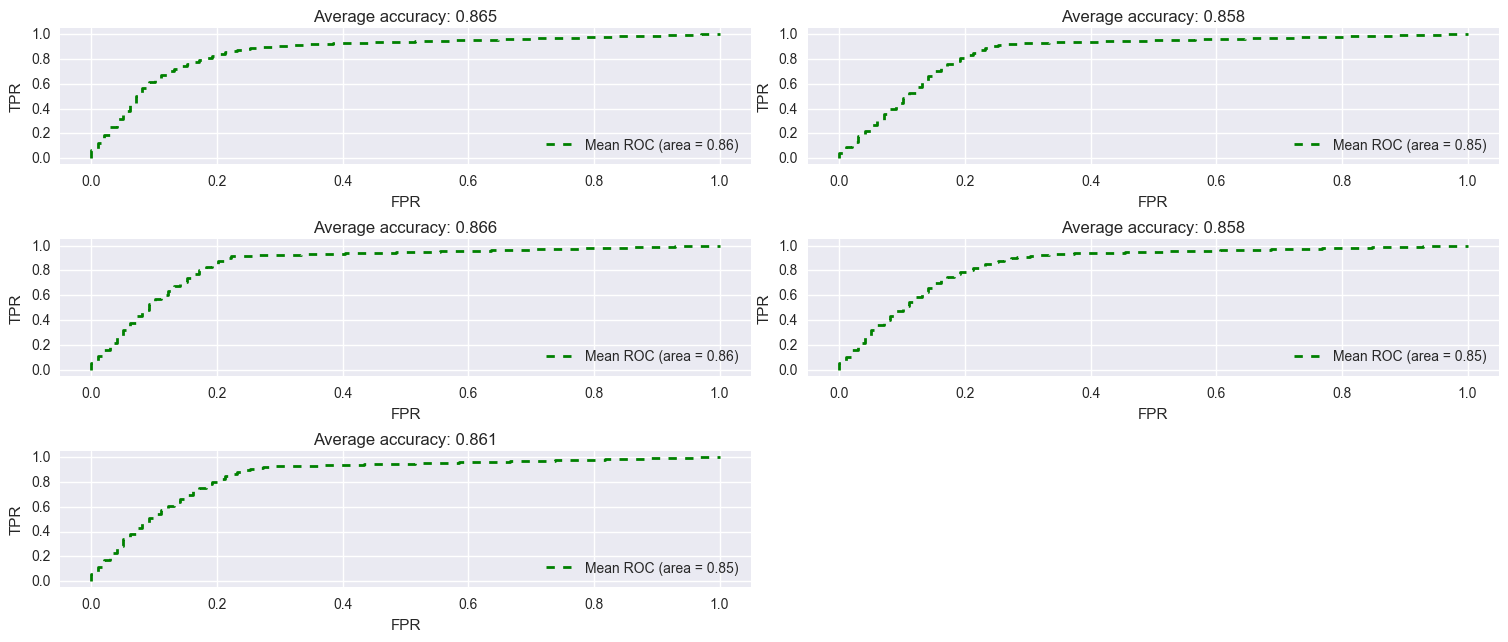

In [52]:
plt.figure(figsize=(15,8))
for i in range(len(randomstate)):
    forest = RandomForestClassifier(n_estimators=600, n_jobs=-1, max_depth = 800,max_features = 'auto',                                   min_samples_leaf =50,random_state=randomstate[i] )
    plt.subplot(4,2,i+1)
    print(algorithm(forest,colors,crx_train,crx_test,pos = None),"random state: ",randomstate[i])
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0) 

Average accuracy: 0.873 (+/-0.034)


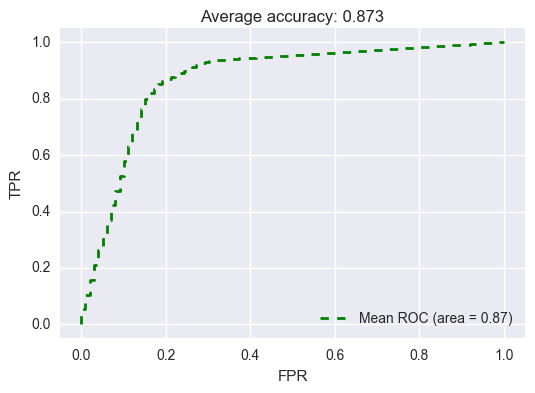

In [53]:
forest = RandomForestClassifier(n_estimators=600, n_jobs=-1, max_depth = 800,max_features = 'auto',                                   min_samples_leaf =50,random_state = None)
print(algorithm(forest,colors,crx_train,crx_test,pos = None))

Average accuracy: 0.865 (+/-0.027) Penalty:  l1
Average accuracy: 0.869 (+/-0.032) Penalty:  l2


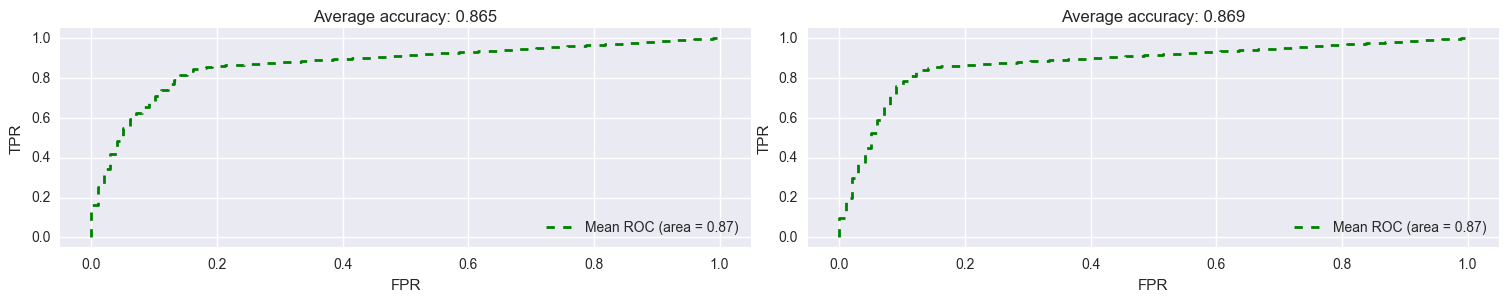

In [54]:
plt.figure(figsize=(15,8))
for i in range(len(penalties)):
    logistic = LogisticRegression(n_jobs = -1, penalty= penalties[i])
    plt.subplot(3,2,i+1)
    print(algorithm(logistic,colors,crx_train,crx_test,pos = None),"Penalty: ",penalties[i])
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)   

Average accuracy: 0.867 (+/-0.028) Solver:  newton-cg
Average accuracy: 0.826 (+/-0.028) Solver:  lbfgs
Average accuracy: 0.862 (+/-0.038) Solver:  liblinear
Average accuracy: 0.668 (+/-0.064) Solver:  sag


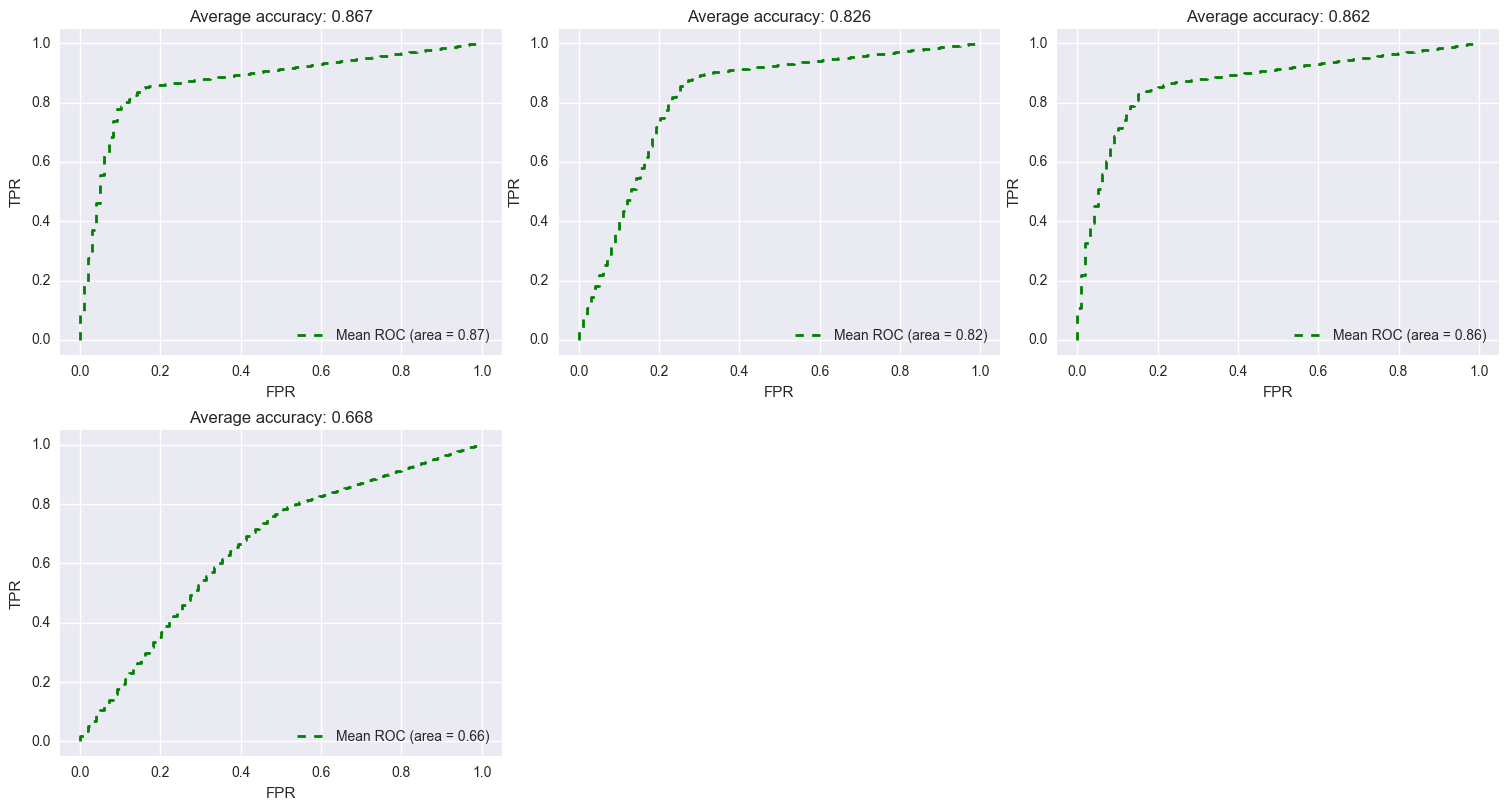

In [55]:
plt.figure(figsize=(15,8))
for i in range(len(solve)):
    logistic = LogisticRegression(n_jobs = -1, penalty= 'l2',  solver = solve[i])
    plt.subplot(2,3,i+1)
    print(algorithm(logistic,colors,crx_train,crx_test,pos = None),"Solver: ",solve[i])
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0) 

Average accuracy: 0.867 (+/-0.039) C:  1.0
Average accuracy: 0.852 (+/-0.032) C:  0.1
Average accuracy: 0.865 (+/-0.024) C:  0.5
Average accuracy: 0.870 (+/-0.047) C:  0.8
Average accuracy: 0.859 (+/-0.041) C:  0.9


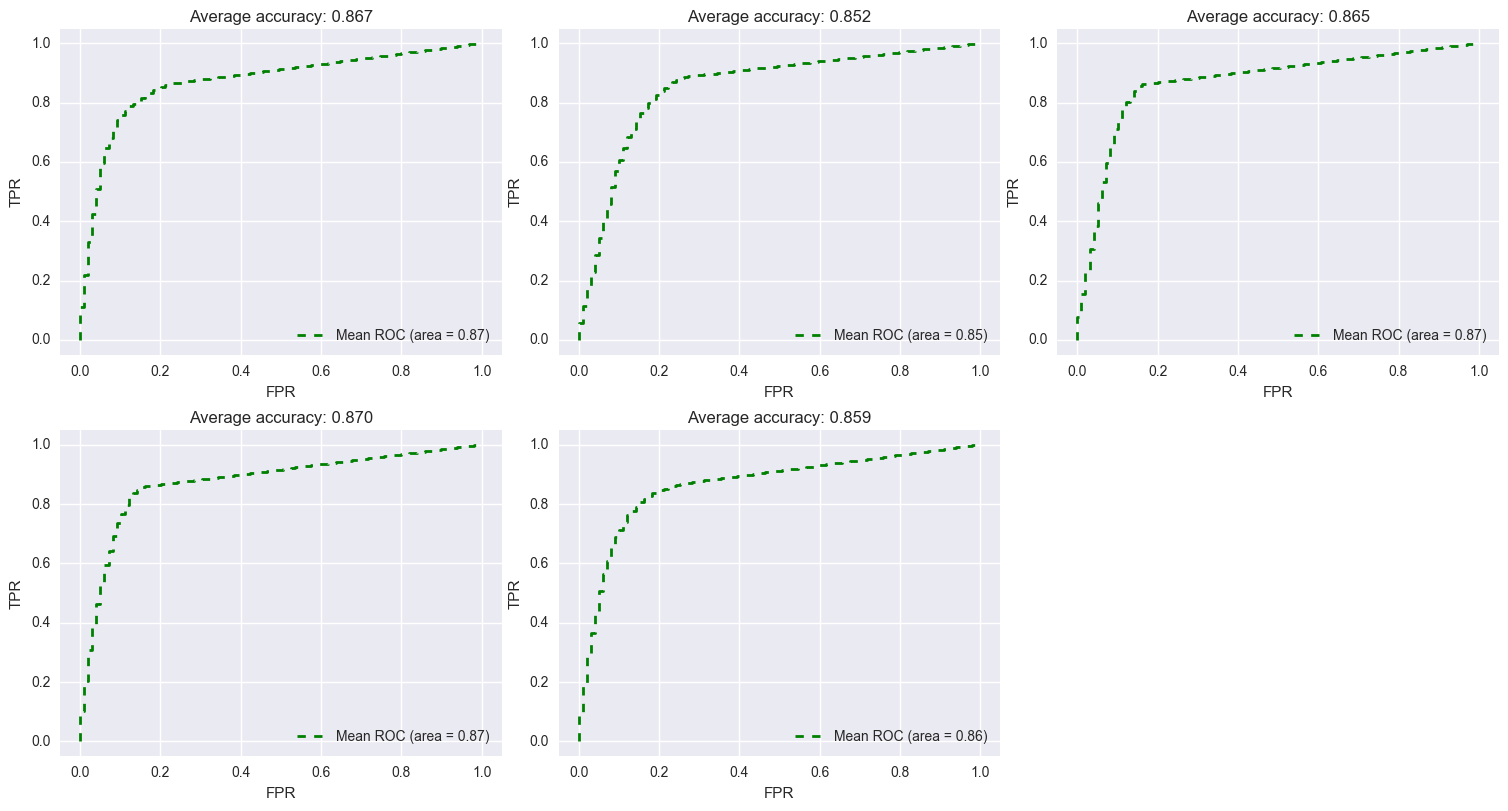

In [56]:
plt.figure(figsize=(15,8))
for i in range(len(cvalue)):
    logistic = LogisticRegression(n_jobs = -1, penalty= 'l2', solver = 'liblinear', C = cvalue[i])
    plt.subplot(2,3,i+1)
    print(algorithm(logistic,colors,crx_train,crx_test,pos = None),"C: ",cvalue[i])
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)

Average accuracy: 0.865 (+/-0.040) Class Weight:  balanced
Average accuracy: 0.865 (+/-0.024) Class Weight:  None


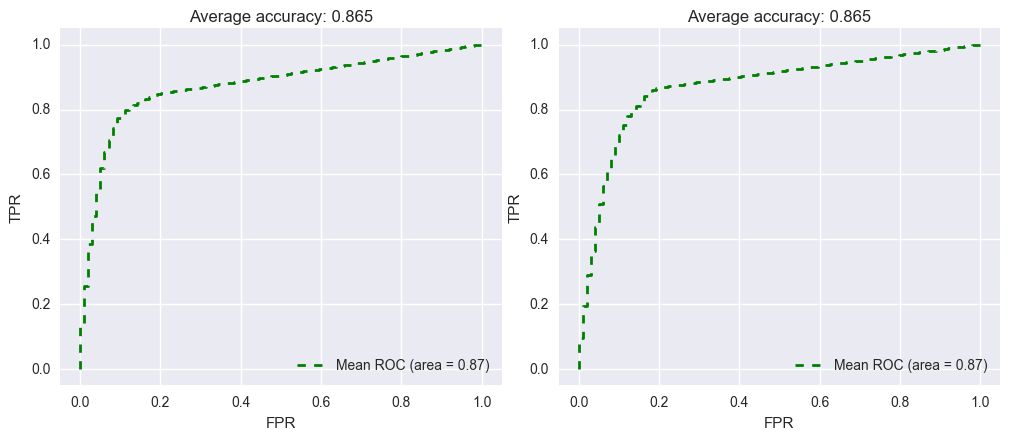

In [57]:
plt.figure(figsize=(15,8))
for i in range(len(classweight)):
    logistic = LogisticRegression(n_jobs = -1, penalty= 'l2', C = 0.5 , solver = 'liblinear',                                  class_weight = classweight[i])
    plt.subplot(2,3,i+1)
    print(algorithm(logistic,colors,crx_train,crx_test,pos = None),"Class Weight: ",classweight[i])
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0) 

Average accuracy: 0.664 (+/-0.040) Max iterations:  10
Average accuracy: 0.864 (+/-0.034) Max iterations:  100
Average accuracy: 0.865 (+/-0.036) Max iterations:  500
Average accuracy: 0.862 (+/-0.027) Max iterations:  1000


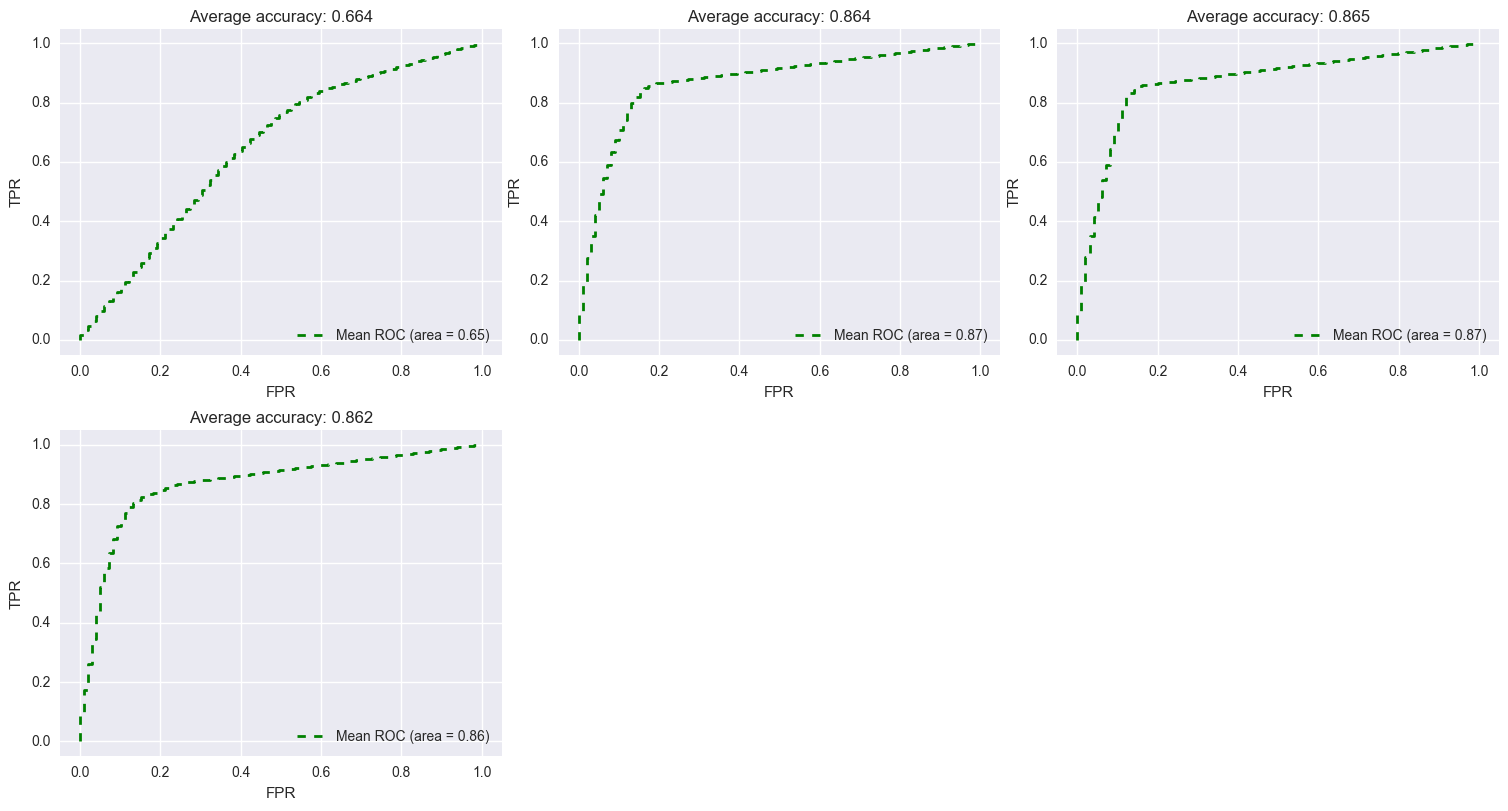

In [58]:
plt.figure(figsize=(15,8))
for i in range(len(max_iter)):
    logistic = LogisticRegression(n_jobs = -1, penalty= 'l2', C = 0.5 , solver = 'liblinear',                                  class_weight = None ,max_iter = max_iter[i])
    plt.subplot(2,3,i+1)
    print(algorithm(logistic,colors,crx_train,crx_test,pos = None),"Max iterations: ",max_iter[i])
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)  

Average accuracy: 0.860 (+/-0.048) Random State:  None
Average accuracy: 0.861 (+/-0.044) Random State:  10
Average accuracy: 0.864 (+/-0.037) Random State:  100
Average accuracy: 0.857 (+/-0.044) Random State:  500
Average accuracy: 0.858 (+/-0.036) Random State:  1000
Average accuracy: 0.867 (+/-0.040) Random State:  1024


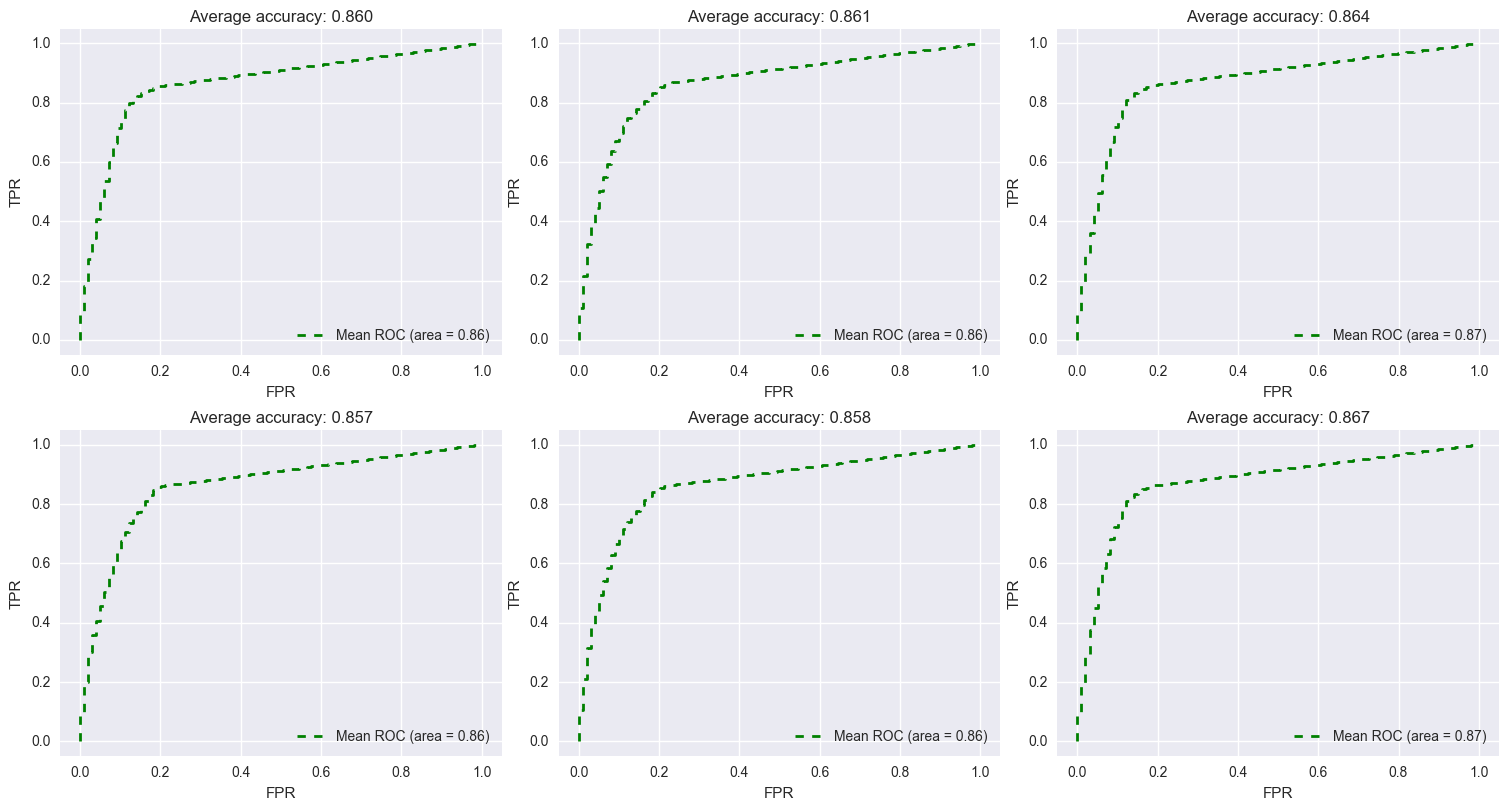

In [59]:
plt.figure(figsize=(15,8))
for i in range(len(randomState)):
    logistic = LogisticRegression(n_jobs = -1, penalty= 'l2', C = 0.5 , solver = 'liblinear',                                  class_weight = None,random_state = randomState[i])
    plt.subplot(2,3,i+1)
    print(algorithm(logistic,colors,crx_train,crx_test,pos = None),"Random State: ",randomState[i])
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)  

Average accuracy: 0.862 (+/-0.045)


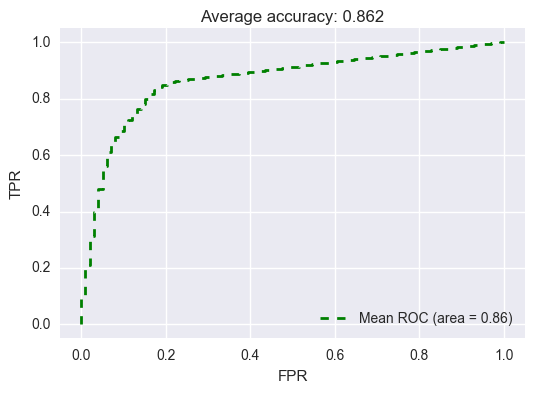

In [60]:
logistic = LogisticRegression(n_jobs = -1, penalty= 'l2', C = 0.5 , solver = 'liblinear',                                  class_weight = None,random_state = 500)
print(algorithm(logistic,colors,crx_train,crx_test,pos = None))

Average accuracy: 0.790 (+/-0.042)


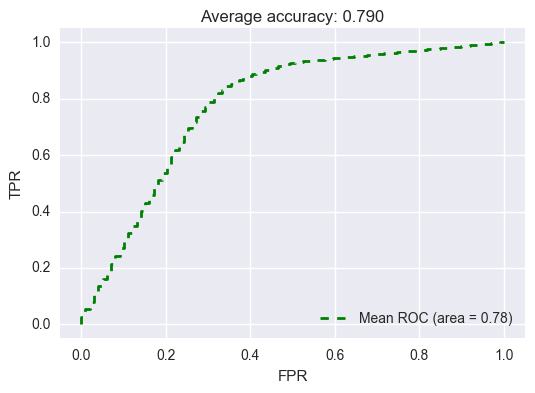

In [61]:
naive = GaussianNB()
print(algorithm(naive,colors,crx_train,crx_test,pos = None))

Average accuracy: 0.664 (+/-0.039) Neighbors:  5
Average accuracy: 0.697 (+/-0.045) Neighbors:  10
Average accuracy: 0.687 (+/-0.040) Neighbors:  50
Average accuracy: 0.684 (+/-0.047) Neighbors:  100


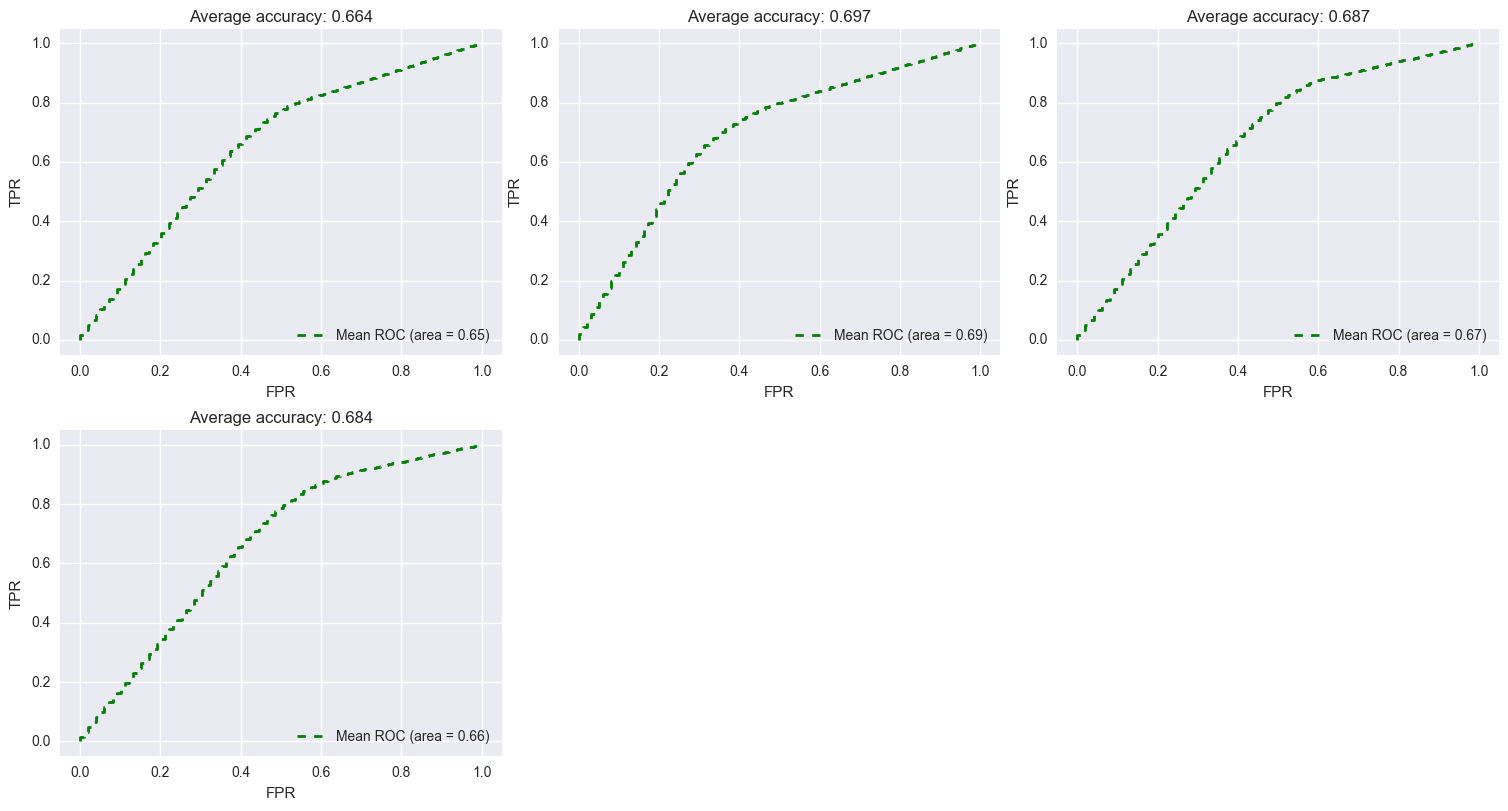

In [62]:
plt.figure(figsize=(15,8))
for i in range(len(neighbors)):
    knneigh = KNeighborsClassifier(n_jobs = -1,n_neighbors= neighbors[i])
    plt.subplot(2,3,i+1)
    print(algorithm(knneigh,colors,crx_train,crx_test,pos = None),"Neighbors: ",neighbors[i])
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0) 

Average accuracy: 0.668 (+/-0.047) Weights:  uniform
Average accuracy: 0.671 (+/-0.029) Weights:  distance


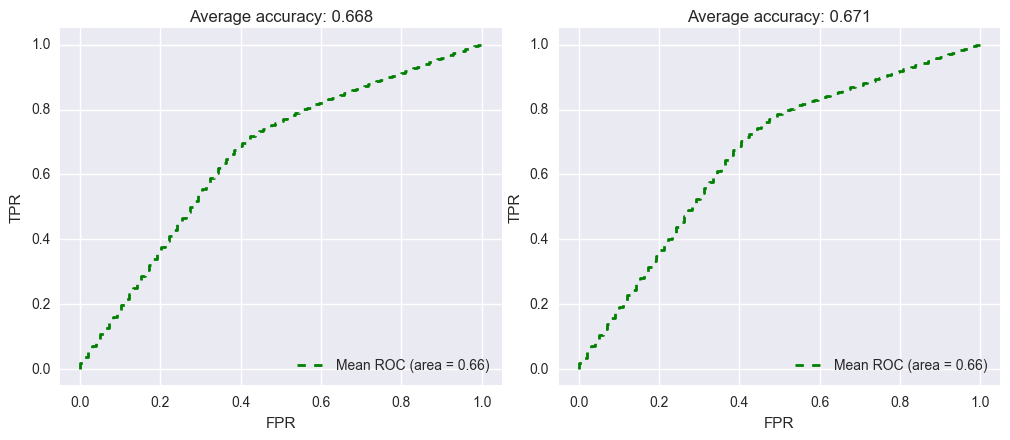

In [63]:
plt.figure(figsize=(15,8))
for i in range(len(weight)):
    knneigh = KNeighborsClassifier(n_jobs = -1,n_neighbors=5, weights = weight[i])
    plt.subplot(2,3,i+1)
    print(algorithm(knneigh,colors,crx_train,crx_test,pos = None),"Weights: ",weight[i])
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0) 

Average accuracy: 0.677 (+/-0.048) Algorithm:  auto
Average accuracy: 0.668 (+/-0.042) Algorithm:  ball_tree
Average accuracy: 0.674 (+/-0.042) Algorithm:  kd_tree
Average accuracy: 0.665 (+/-0.048) Algorithm:  brute


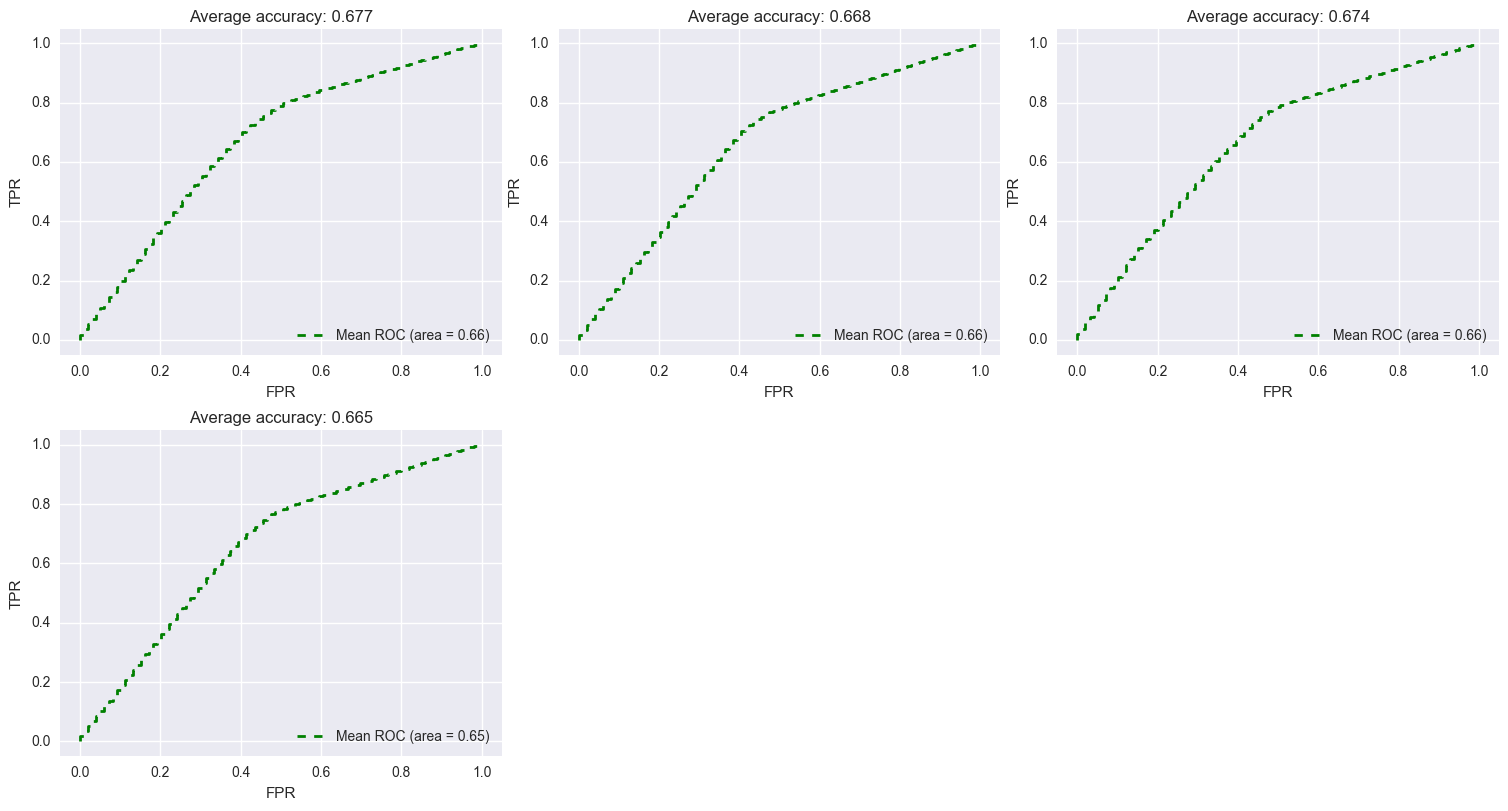

In [64]:
plt.figure(figsize=(15,8))
for i in range(len(algo)):
    knneigh = KNeighborsClassifier(n_jobs = -1,n_neighbors=5, weights = 'uniform', algorithm = algo[i])
    plt.subplot(2,3,i+1)
    print(algorithm(knneigh,colors,crx_train,crx_test,pos = None),"Algorithm: ",algo[i])
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0) 

Average accuracy: 0.668 (+/-0.048)


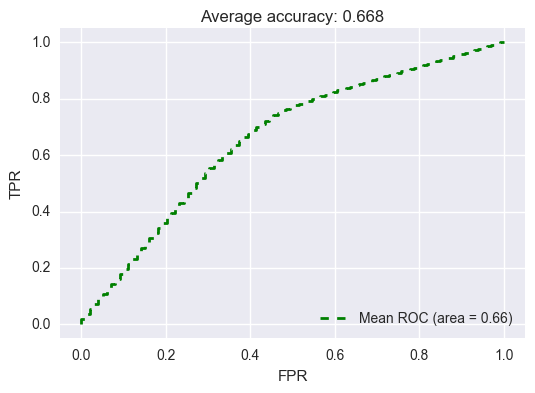

In [65]:
knneigh = KNeighborsClassifier(n_jobs = -1,n_neighbors=5, weights = 'uniform', algorithm = 'auto')
print(algorithm(knneigh,colors,crx_train,crx_test,pos = None))

Average accuracy: 0.731 (+/-0.075) Dual:  True
Average accuracy: 0.855 (+/-0.031) Dual:  False


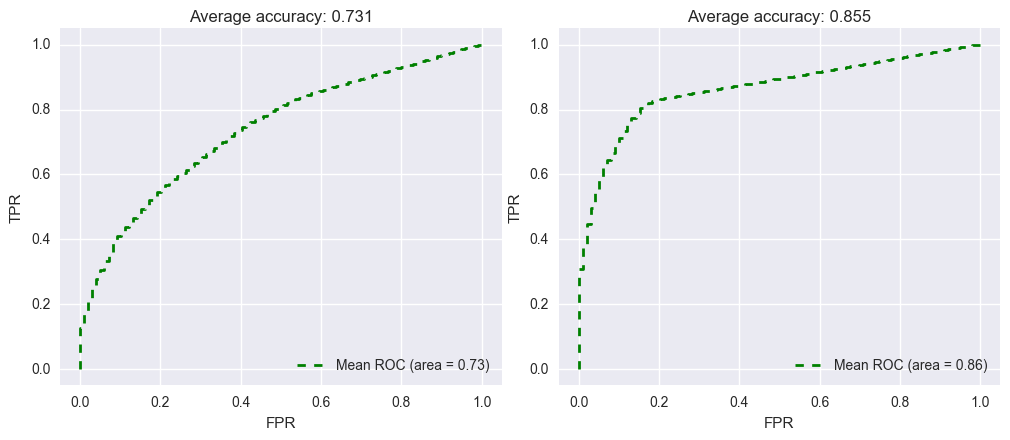

In [66]:
plt.figure(figsize=(15,8))
for i in range(len(dual)):
    svm = LinearSVC(dual = dual[i])
    plt.subplot(2,3,i+1)
    print(algorithm(svm,colors,crx_train,crx_test,pos = None),"Dual: ",dual[i])
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0) 

Average accuracy: 0.855 (+/-0.035) C:  1.0
Average accuracy: 0.855 (+/-0.052) C:  0.1
Average accuracy: 0.855 (+/-0.031) C:  0.5
Average accuracy: 0.855 (+/-0.038) C:  0.8
Average accuracy: 0.858 (+/-0.043) C:  0.9


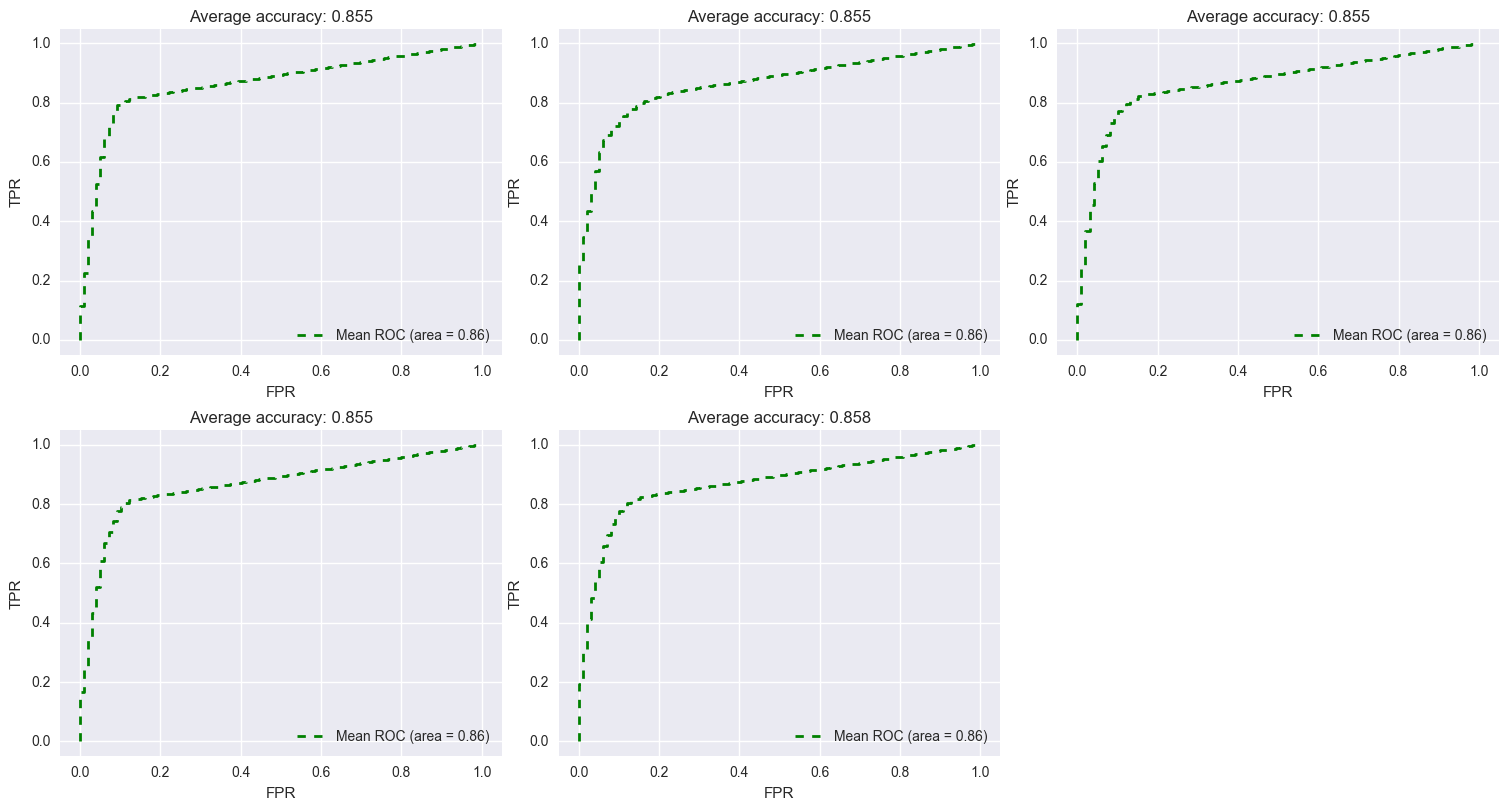

In [67]:
plt.figure(figsize=(15,8))
for i in range(len(cvalue)):
    svm = LinearSVC(dual = False, C = cvalue[i])
    plt.subplot(2,3,i+1)
    print(algorithm(svm,colors,crx_train,crx_test,pos = None),"C: ",cvalue[i])
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)  

Average accuracy: 0.855 (+/-0.022) Penalty:  l1
Average accuracy: 0.856 (+/-0.041) Penalty:  l2


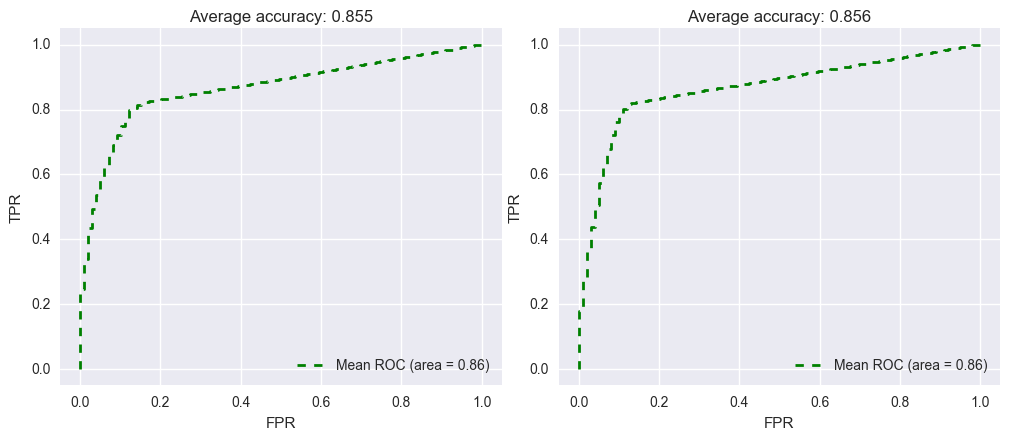

In [68]:
plt.figure(figsize=(15,8))
for i in range(len(penalties)):
    svm = LinearSVC(dual = False, C = 1, penalty = penalties[i])
    plt.subplot(2,3,i+1)
    print(algorithm(svm,colors,crx_train,crx_test,pos = None),"Penalty: ",penalties[i])
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0) 

Average accuracy: 0.857 (+/-0.039) Class Weight:  balanced
Average accuracy: 0.859 (+/-0.043) Class Weight:  None


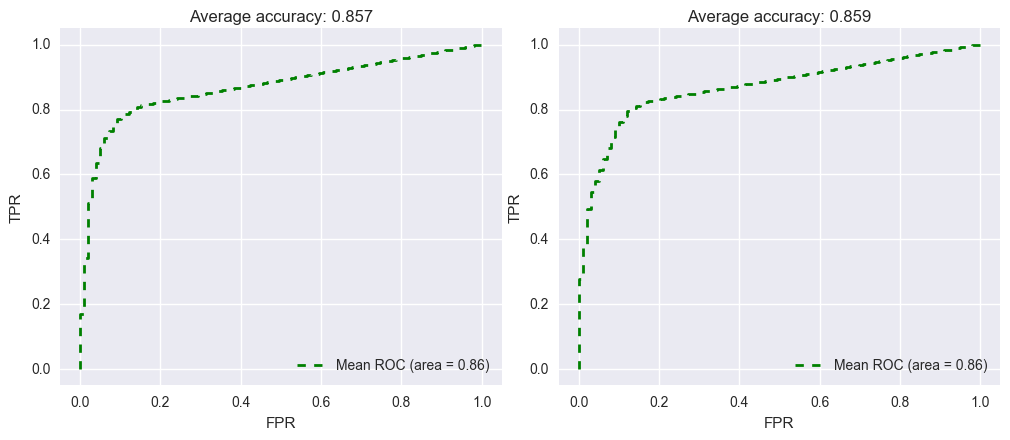

In [69]:
plt.figure(figsize=(15,8))
for i in range(len(classweight)):
    svm = LinearSVC(dual = False, C = 1, penalty = 'l1', class_weight=classweight[i])
    plt.subplot(2,3,i+1)
    print(algorithm(svm,colors,crx_train,crx_test,pos = None),"Class Weight: ",classweight[i])
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0) 

Average accuracy: 0.857 (+/-0.028) Max Iterations:  10
Average accuracy: 0.857 (+/-0.028) Max Iterations:  100
Average accuracy: 0.860 (+/-0.044) Max Iterations:  500
Average accuracy: 0.857 (+/-0.038) Max Iterations:  1000


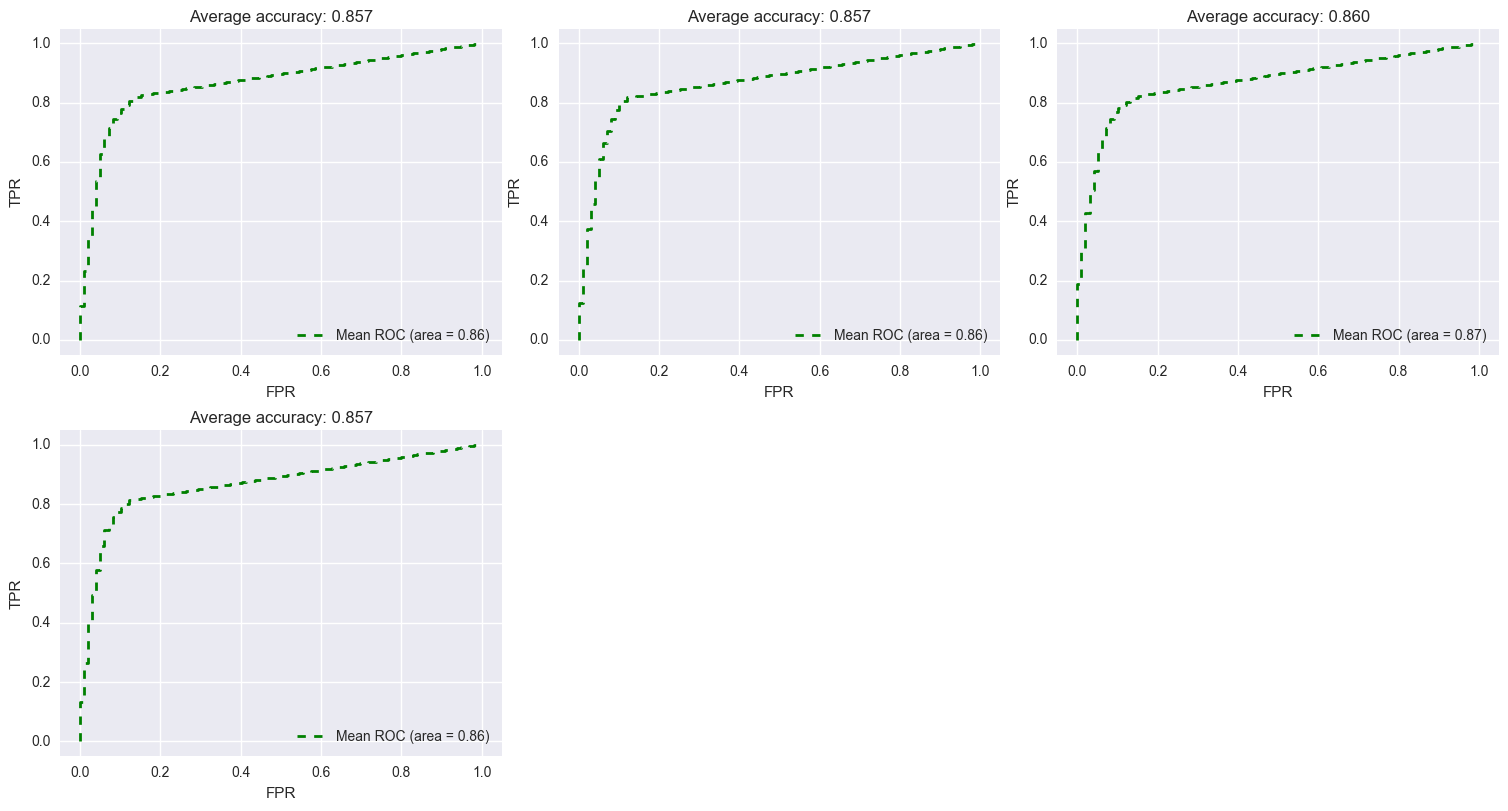

In [70]:
plt.figure(figsize=(15,8))
for i in range(len(max_iter)):
    svm = LinearSVC(dual = False, C = 1, penalty = 'l1', class_weight=None,max_iter=max_iter[i])
    plt.subplot(2,3,i+1)
    print(algorithm(svm,colors,crx_train,crx_test,pos = None),"Max Iterations: ",max_iter[i])
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0) 

Average accuracy: 0.851 (+/-0.044) Random State:  None
Average accuracy: 0.855 (+/-0.042) Random State:  10
Average accuracy: 0.858 (+/-0.035) Random State:  100
Average accuracy: 0.859 (+/-0.040) Random State:  500
Average accuracy: 0.861 (+/-0.040) Random State:  1000
Average accuracy: 0.853 (+/-0.038) Random State:  1024


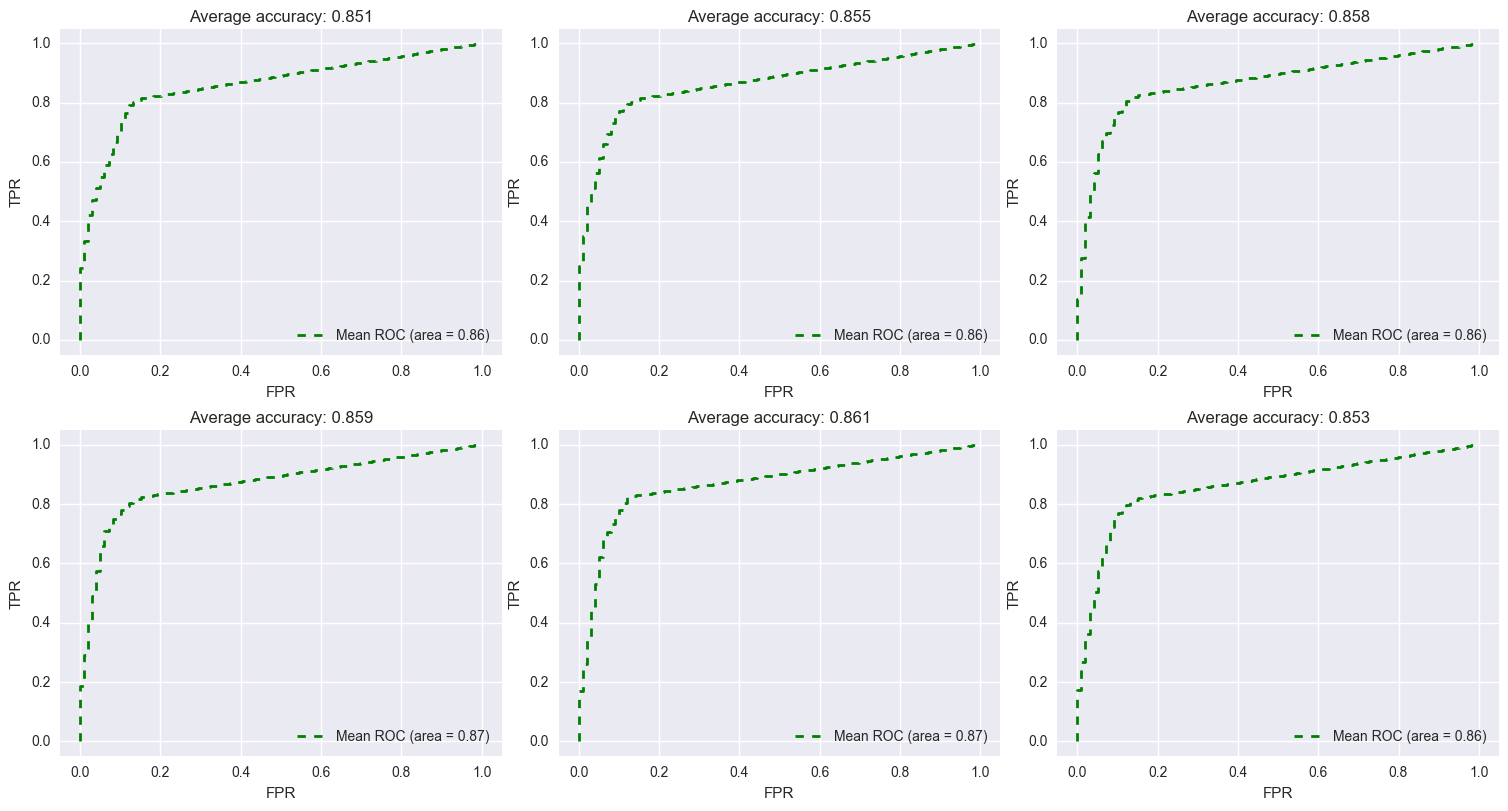

In [71]:
plt.figure(figsize=(15,8))
for i in range(len(randomState)):
    svm = LinearSVC(dual = False, C = 1, penalty = 'l1', class_weight=None,max_iter=1000,random_state=randomState[i])
    plt.subplot(2,3,i+1)
    print(algorithm(svm,colors,crx_train,crx_test,pos = None),"Random State: ",randomState[i])
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0) 

Average accuracy: 0.861 (+/-0.049)


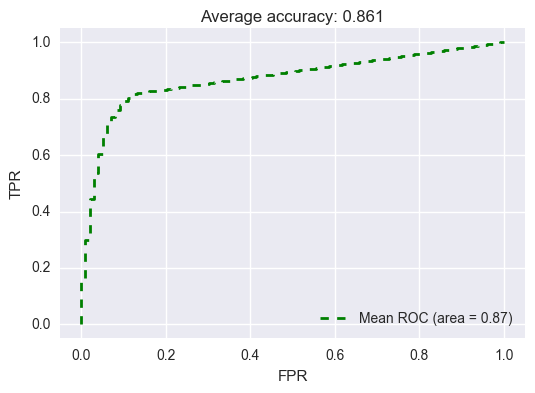

In [72]:
svm = LinearSVC(dual = False, C = 1, penalty = 'l1', class_weight=None,max_iter=1000,random_state=1000)
print(algorithm(svm,colors,crx_train,crx_test,pos = None))

In [73]:
X_train, X_test, y_train, y_test = train_test_split(crx.iloc[:,:-1], crx.iloc[:,-1:], test_size=0.20, random_state=4212)
train = pd.concat([X_train, y_train], axis=1)

In [74]:
predictions = []
for i,c in X_test.iterrows():
    neigh = knn(train,c,5)
    responses = majorityVote(neigh)
    predictions.append(responses)
mine_knn = pd.DataFrame( data={"predicted":predictions,"actual":y_test.values.ravel()} ) 
print ("accuracy_score: ", accuracy_score(mine_knn['actual'],mine_knn['predicted']))

accuracy_score:  0.666666666667


In [75]:
#Due to Memory constraints, deleting some variables to free space
del german,german_train, german_test
del crx,crx_train,crx_test

default of credit card clients Data Set 

In [76]:
default = pd.read_excel('default of credit card clients.xls',skiprows=1)
default=default.rename(columns = {'default payment next month':'default'})
default.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 25 columns):
ID           30000 non-null int64
LIMIT_BAL    30000 non-null int64
SEX          30000 non-null int64
EDUCATION    30000 non-null int64
MARRIAGE     30000 non-null int64
AGE          30000 non-null int64
PAY_0        30000 non-null int64
PAY_2        30000 non-null int64
PAY_3        30000 non-null int64
PAY_4        30000 non-null int64
PAY_5        30000 non-null int64
PAY_6        30000 non-null int64
BILL_AMT1    30000 non-null int64
BILL_AMT2    30000 non-null int64
BILL_AMT3    30000 non-null int64
BILL_AMT4    30000 non-null int64
BILL_AMT5    30000 non-null int64
BILL_AMT6    30000 non-null int64
PAY_AMT1     30000 non-null int64
PAY_AMT2     30000 non-null int64
PAY_AMT3     30000 non-null int64
PAY_AMT4     30000 non-null int64
PAY_AMT5     30000 non-null int64
PAY_AMT6     30000 non-null int64
default      30000 non-null int64
dtypes: int64(25)
memory usage: 5.7 MB


In [77]:
default_train,default_test = default.iloc[:,1:len(default.columns)-1],default.iloc[:,len(default.columns)-1]
default['default'].value_counts()

0    23364
1     6636
Name: default, dtype: int64

Average accuracy: 0.805 (+/-0.005) estimators:  10
Average accuracy: 0.815 (+/-0.004) estimators:  100
Average accuracy: 0.817 (+/-0.005) estimators:  300
Average accuracy: 0.817 (+/-0.005) estimators:  600
Average accuracy: 0.817 (+/-0.005) estimators:  800
Average accuracy: 0.816 (+/-0.005) estimators:  1000


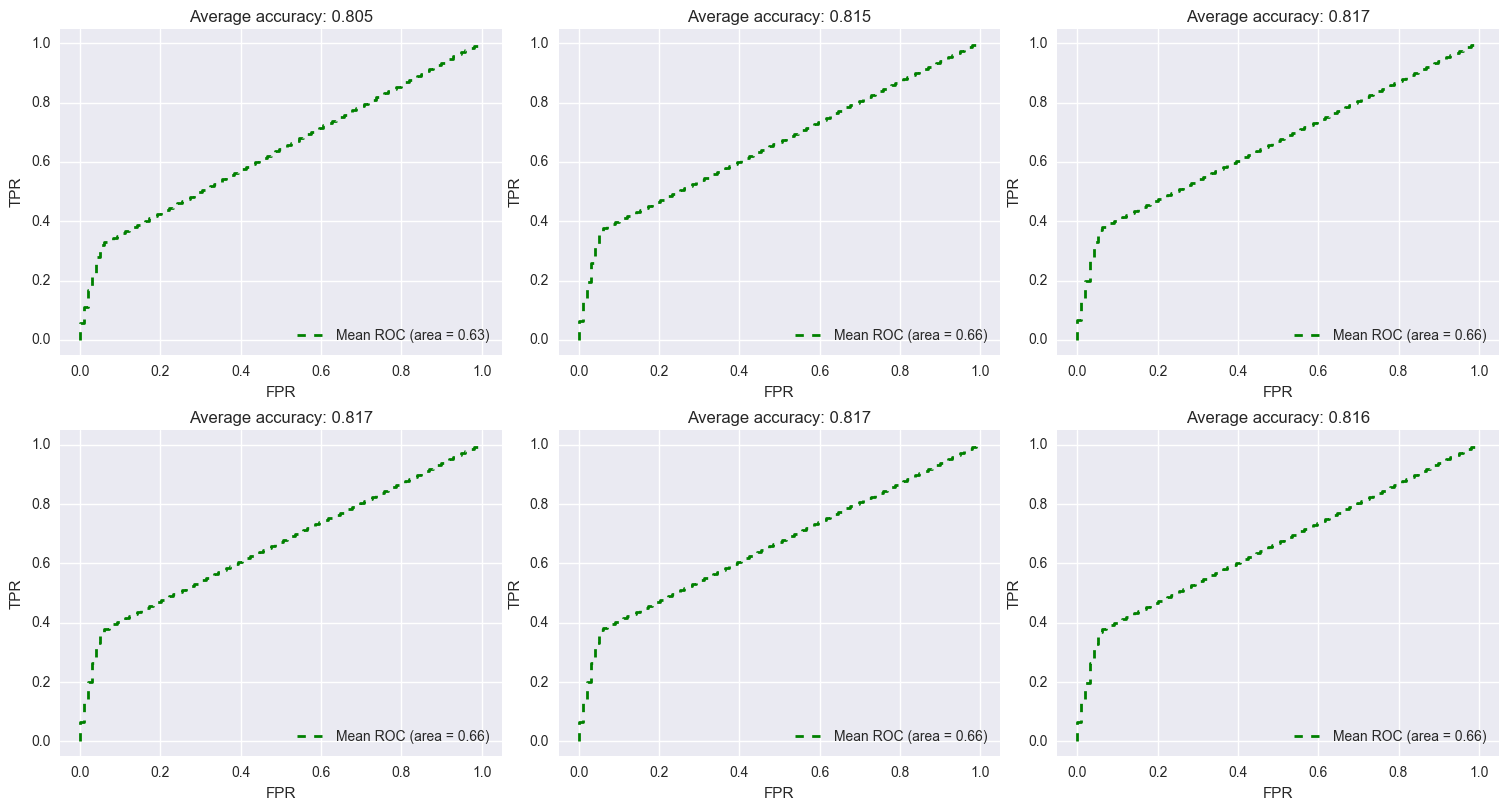

In [78]:
plt.figure(figsize=(15,8))

for i in range(len(estimators)):
    forest = RandomForestClassifier(n_estimators=estimators[i], n_jobs=-1)
    plt.subplot(2,3,i+1)
    print(algorithm(forest,colors,default_train,default_test,pos = None),"estimators: ",estimators[i])
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)   

Average accuracy: 0.782 (+/-0.001) maximum depth:  1
Average accuracy: 0.802 (+/-0.003) maximum depth:  2
Average accuracy: 0.817 (+/-0.005) maximum depth:  50
Average accuracy: 0.817 (+/-0.006) maximum depth:  100
Average accuracy: 0.816 (+/-0.007) maximum depth:  300
Average accuracy: 0.817 (+/-0.006) maximum depth:  800
Average accuracy: 0.817 (+/-0.005) maximum depth:  None


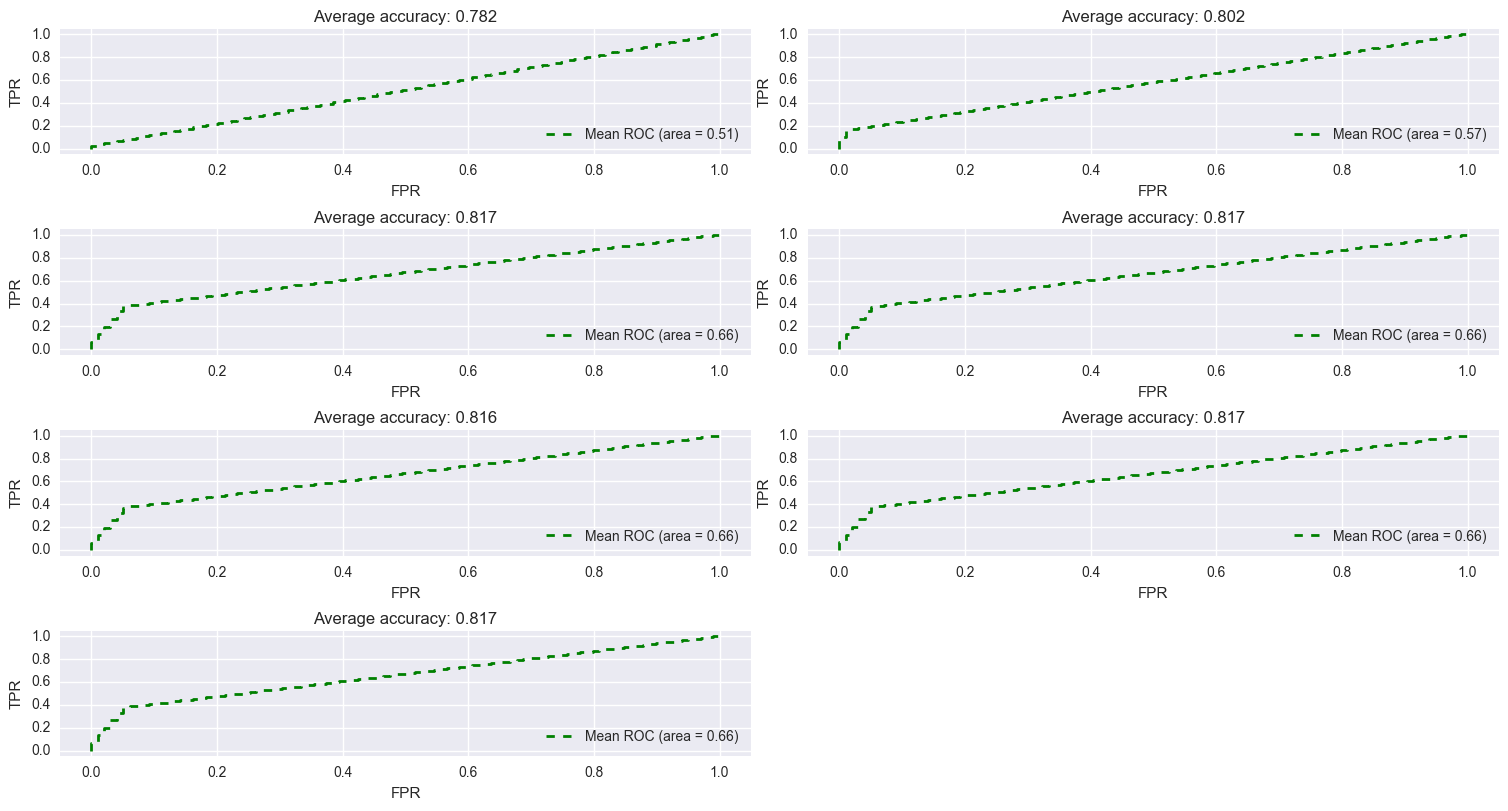

In [79]:
plt.figure(figsize=(15,8))
for i in range(len(depth)):
    forest = RandomForestClassifier(n_estimators=600, n_jobs=-1, max_depth = depth[i])
    plt.subplot(4,2,i+1)
    print(algorithm(forest,colors,default_train,default_test,pos = None),"maximum depth: ",depth[i])
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)  

Average accuracy: 0.817 (+/-0.005) max features:  auto
Average accuracy: 0.817 (+/-0.005) max features:  sqrt
Average accuracy: 0.816 (+/-0.007) max features:  0.2


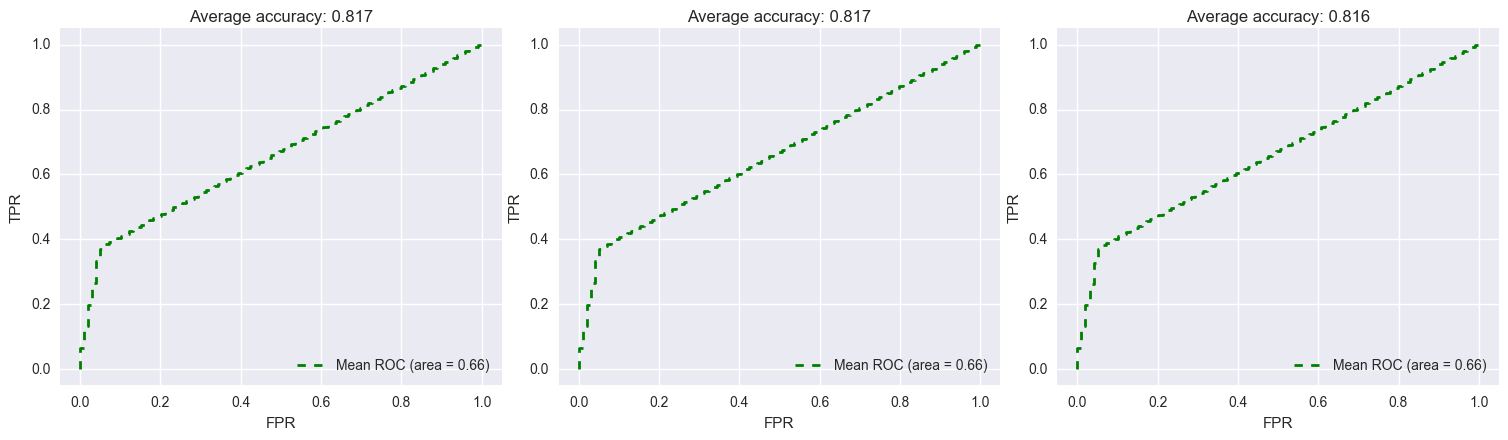

In [ ]:
plt.figure(figsize=(15,8))
for i in range(len(features)):
    forest = RandomForestClassifier(n_estimators=600, n_jobs=-1, max_depth = 800,   \
                                    max_features = features[i])
    plt.subplot(2,3,i+1)
    print(algorithm(forest,colors,default_train,default_test,pos = None),"max features: ",features[i])
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)    

In [ ]:
plt.figure(figsize=(15,8))
for i in range(len(min_sampleleaf)):
    forest = RandomForestClassifier(n_estimators=600, n_jobs=-1, max_depth = 800,max_features = 'auto',  \
                                    min_samples_leaf =min_sampleleaf[i] )
    plt.subplot(4,2,i+1)
    print(algorithm(forest,colors,default_train,default_test,pos = None),"min sample leaf: ",min_sampleleaf[i])
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0) 

In [ ]:
plt.figure(figsize=(15,8))
for i in range(len(randomstate)):
    forest = RandomForestClassifier(n_estimators=600, n_jobs=-1, max_depth = 800,max_features = 'auto',  \
                                    min_samples_leaf =50,random_state=randomstate[i] )
    plt.subplot(4,2,i+1)
    print(algorithm(forest,colors,default_train,default_test,pos = None),"random state: ",randomstate[i])
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)    

In [ ]:
forest = RandomForestClassifier(n_estimators=600, n_jobs=-1, max_depth = 800,max_features = 'auto',   \
                                min_samples_leaf =50,random_state = None)
print(algorithm(forest,colors,default_train,default_test,pos = None))

In [ ]:
plt.figure(figsize=(15,8))
for i in range(len(penalties)):
    logistic = LogisticRegression(n_jobs = -1, penalty= penalties[i])
    plt.subplot(3,2,i+1)
    print(algorithm(logistic,colors,default_train,default_test,pos = None),"Penalty: ",penalties[i])
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)  

In [ ]:
plt.figure(figsize=(15,8))
for i in range(len(solve)):
    logistic = LogisticRegression(n_jobs = -1, penalty= 'l2',  solver = solve[i])
    plt.subplot(2,3,i+1)
    print(algorithm(logistic,colors,default_train,default_test,pos = None),"Solver: ",solve[i])
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)

In [ ]:
plt.figure(figsize=(15,8))
for i in range(len(cvalue)):
    logistic = LogisticRegression(n_jobs = -1, penalty= 'l2', solver = 'liblinear', C = cvalue[i])\
    
    plt.subplot(2,3,i+1)
    print(algorithm(logistic,colors,default_train,default_test,pos = None),"C: ",cvalue[i])
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)

In [ ]:
plt.figure(figsize=(15,8))
for i in range(len(classweight)):
    logistic = LogisticRegression(n_jobs = -1, penalty= 'l2', C = 0.5 , solver = 'liblinear',  \
                                  class_weight = classweight[i])
    plt.subplot(2,3,i+1)
    print(algorithm(logistic,colors,default_train,default_test,pos = None),"Class Weight: ",classweight[i])
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0) 

In [ ]:
plt.figure(figsize=(15,8))
for i in range(len(max_iter)):
    logistic = LogisticRegression(n_jobs = -1, penalty= 'l2', C = 0.5 , solver = 'liblinear', \
                                  class_weight = None ,max_iter = max_iter[i])
    plt.subplot(2,3,i+1)
    print(algorithm(logistic,colors,default_train,default_test,pos = None),"Max iterations: ",max_iter[i])
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0) 

In [ ]:
plt.figure(figsize=(15,8))
for i in range(len(randomState)):
    logistic = LogisticRegression(n_jobs = -1, penalty= 'l2', C = 0.5 , solver = 'liblinear', \
                                  class_weight = None,random_state = randomState[i])
    plt.subplot(2,3,i+1)
    print(algorithm(logistic,colors,default_train,default_test,pos = None),"Random State: ",randomState[i])
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)

In [ ]:
logistic = LogisticRegression(n_jobs = -1, penalty= 'l2', C = 0.5 , solver = 'liblinear',  \
                              class_weight = None,random_state = 500)
print(algorithm(logistic,colors,default_train,default_test,pos = None))

In [ ]:
naive = GaussianNB()
print(algorithm(naive,colors,default_train,default_test,pos = None))

In [ ]:
plt.figure(figsize=(15,8))
for i in range(len(neighbors)):
    knneigh = KNeighborsClassifier(n_jobs = -1,n_neighbors= neighbors[i])
    plt.subplot(2,3,i+1)
    print(algorithm(knneigh,colors,default_train,default_test,pos = None),"Neighbors: ",neighbors[i])
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0) 

In [ ]:
plt.figure(figsize=(15,8))
for i in range(len(weight)):
    knneigh = KNeighborsClassifier(n_jobs = -1,n_neighbors=5, weights = weight[i])
    plt.subplot(2,3,i+1)
    print(algorithm(knneigh,colors,default_train,default_test,pos = None),"Weights: ",weight[i])
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0) 

In [ ]:
plt.figure(figsize=(15,8))
for i in range(len(algo)):
    knneigh = KNeighborsClassifier(n_jobs = -1,n_neighbors=5, weights = 'uniform', algorithm = algo[i])
    plt.subplot(2,3,i+1)
    print(algorithm(knneigh,colors,default_train,default_test,pos = None),"Algorithm: ",algo[i])
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0) 

In [ ]:
knneigh = KNeighborsClassifier(n_jobs = -1,n_neighbors=5, weights = 'uniform', algorithm = 'auto')
print(algorithm(knneigh,colors,default_train,default_test,pos = None))

In [ ]:
plt.figure(figsize=(15,8))
for i in range(len(dual)):
    svm = LinearSVC(dual = dual[i])
    plt.subplot(2,3,i+1)
    print(algorithm(svm,colors,default_train,default_test,pos = None),"Dual: ",dual[i])
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0) 

In [ ]:
plt.figure(figsize=(15,8))
for i in range(len(cvalue)):
    svm = LinearSVC(dual = False, C = cvalue[i])
    plt.subplot(2,3,i+1)
    print(algorithm(svm,colors,default_train,default_test,pos = None),"C: ",cvalue[i])
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0) 

In [ ]:
plt.figure(figsize=(15,8))
for i in range(len(penalties)):
    svm = LinearSVC(dual = False, C = 1, penalty = penalties[i])
    plt.subplot(2,3,i+1)
    print(algorithm(svm,colors,default_train,default_test,pos = None),"Penalty: ",penalties[i])
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0) 

In [ ]:
plt.figure(figsize=(15,8))
for i in range(len(classweight)):
    svm = LinearSVC(dual = False, C = 1, penalty = 'l1', class_weight=classweight[i])
    plt.subplot(2,3,i+1)
    print(algorithm(svm,colors,default_train,default_test,pos = None),"Class Weight: ",classweight[i])
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0) 

In [ ]:
plt.figure(figsize=(15,8))
for i in range(len(max_iter)):
    svm = LinearSVC(dual = False, C = 1, penalty = 'l1', class_weight=None,max_iter=max_iter[i])
    plt.subplot(2,3,i+1)
    print(algorithm(svm,colors,default_train,default_test,pos = None),"Max Iterations: ",max_iter[i])
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0) 

In [ ]:
plt.figure(figsize=(15,8))
for i in range(len(randomState)):
    svm = LinearSVC(dual = False, C = 1, penalty = 'l1', class_weight=None,max_iter=1000,random_state=randomState[i])
    plt.subplot(2,3,i+1)
    print(algorithm(svm,colors,default_train,default_test,pos = None),"Random State: ",randomState[i])
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0) 

In [ ]:
svm = LinearSVC(dual = False, C = 1, penalty = 'l1', class_weight=None,max_iter=1000,random_state=1000)
print(algorithm(svm,colors,default_train,default_test,pos = None))

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(default.iloc[:,:-1], default.iloc[:,-1:], test_size=0.20, random_state=4212)
train = pd.concat([X_train, y_train], axis=1)

In [ ]:
predictions = []
for i,c in X_test.iterrows():
    neigh = knn(train,c,5)
    responses = majorityVote(neigh)
    predictions.append(responses)
mine_knn = pd.DataFrame( data={"predicted":predictions,"actual":y_test.values.ravel()} ) 
print ("accuracy_score: ", accuracy_score(mine_knn['actual'],mine_knn['predicted']))

Using cross_val_score

Finding Accuracy:

Optional Method 1:

Optional Method 2: